# Task 1

## Loading Libraries & Dataframe

In [1]:
# Core modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import missingno as msno
import re
import joblib
import os

# Scipy & Statsmodels
from scipy import stats
from scipy.stats import skew, boxcox, mstats, randint
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scikit-Learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import TargetEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Scikit-Optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [2]:
path_df = pd.read_csv(r"laptop_prices.csv")
path_df

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,4,Windows 10,1.80,638.00,Full HD,1920,...,No,Intel,2.5,Core i7 6500U,128,0,SSD,No,Intel,HD Graphics 520
1271,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,16,Windows 10,1.30,1499.00,Quad HD+,3200,...,No,Intel,2.5,Core i7 6500U,512,0,SSD,No,Intel,HD Graphics 520
1272,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,2,Windows 10,1.50,229.00,Standard,1366,...,No,Intel,1.6,Celeron Dual Core N3050,64,0,Flash Storage,No,Intel,HD Graphics
1273,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,6,Windows 10,2.19,764.00,Standard,1366,...,No,Intel,2.5,Core i7 6500U,1024,0,HDD,No,AMD,Radeon R5 M330


## Transformers

In [3]:
from custom_transformers import (
    CPUSeriesExtractor,
    GPUSeriesExtractor,
    CardinalityReducer,
    PixelCalculator,
    LogTransformer,
    ColumnDropper,
    KMeansClusterAdder
)

## A quick overview **(EDA)**

In [4]:
path_df.columns

Index(['Company', 'Product', 'TypeName', 'Inches', 'Ram', 'OS', 'Weight',
       'Price_euros', 'Screen', 'ScreenW', 'ScreenH', 'Touchscreen',
       'IPSpanel', 'RetinaDisplay', 'CPU_company', 'CPU_freq', 'CPU_model',
       'PrimaryStorage', 'SecondaryStorage', 'PrimaryStorageType',
       'SecondaryStorageType', 'GPU_company', 'GPU_model'],
      dtype='object')

In [5]:
path_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   Product               1275 non-null   object 
 2   TypeName              1275 non-null   object 
 3   Inches                1275 non-null   float64
 4   Ram                   1275 non-null   int64  
 5   OS                    1275 non-null   object 
 6   Weight                1275 non-null   float64
 7   Price_euros           1275 non-null   float64
 8   Screen                1275 non-null   object 
 9   ScreenW               1275 non-null   int64  
 10  ScreenH               1275 non-null   int64  
 11  Touchscreen           1275 non-null   object 
 12  IPSpanel              1275 non-null   object 
 13  RetinaDisplay         1275 non-null   object 
 14  CPU_company           1275 non-null   object 
 15  CPU_freq             

No missing values in the dataset

<Axes: >

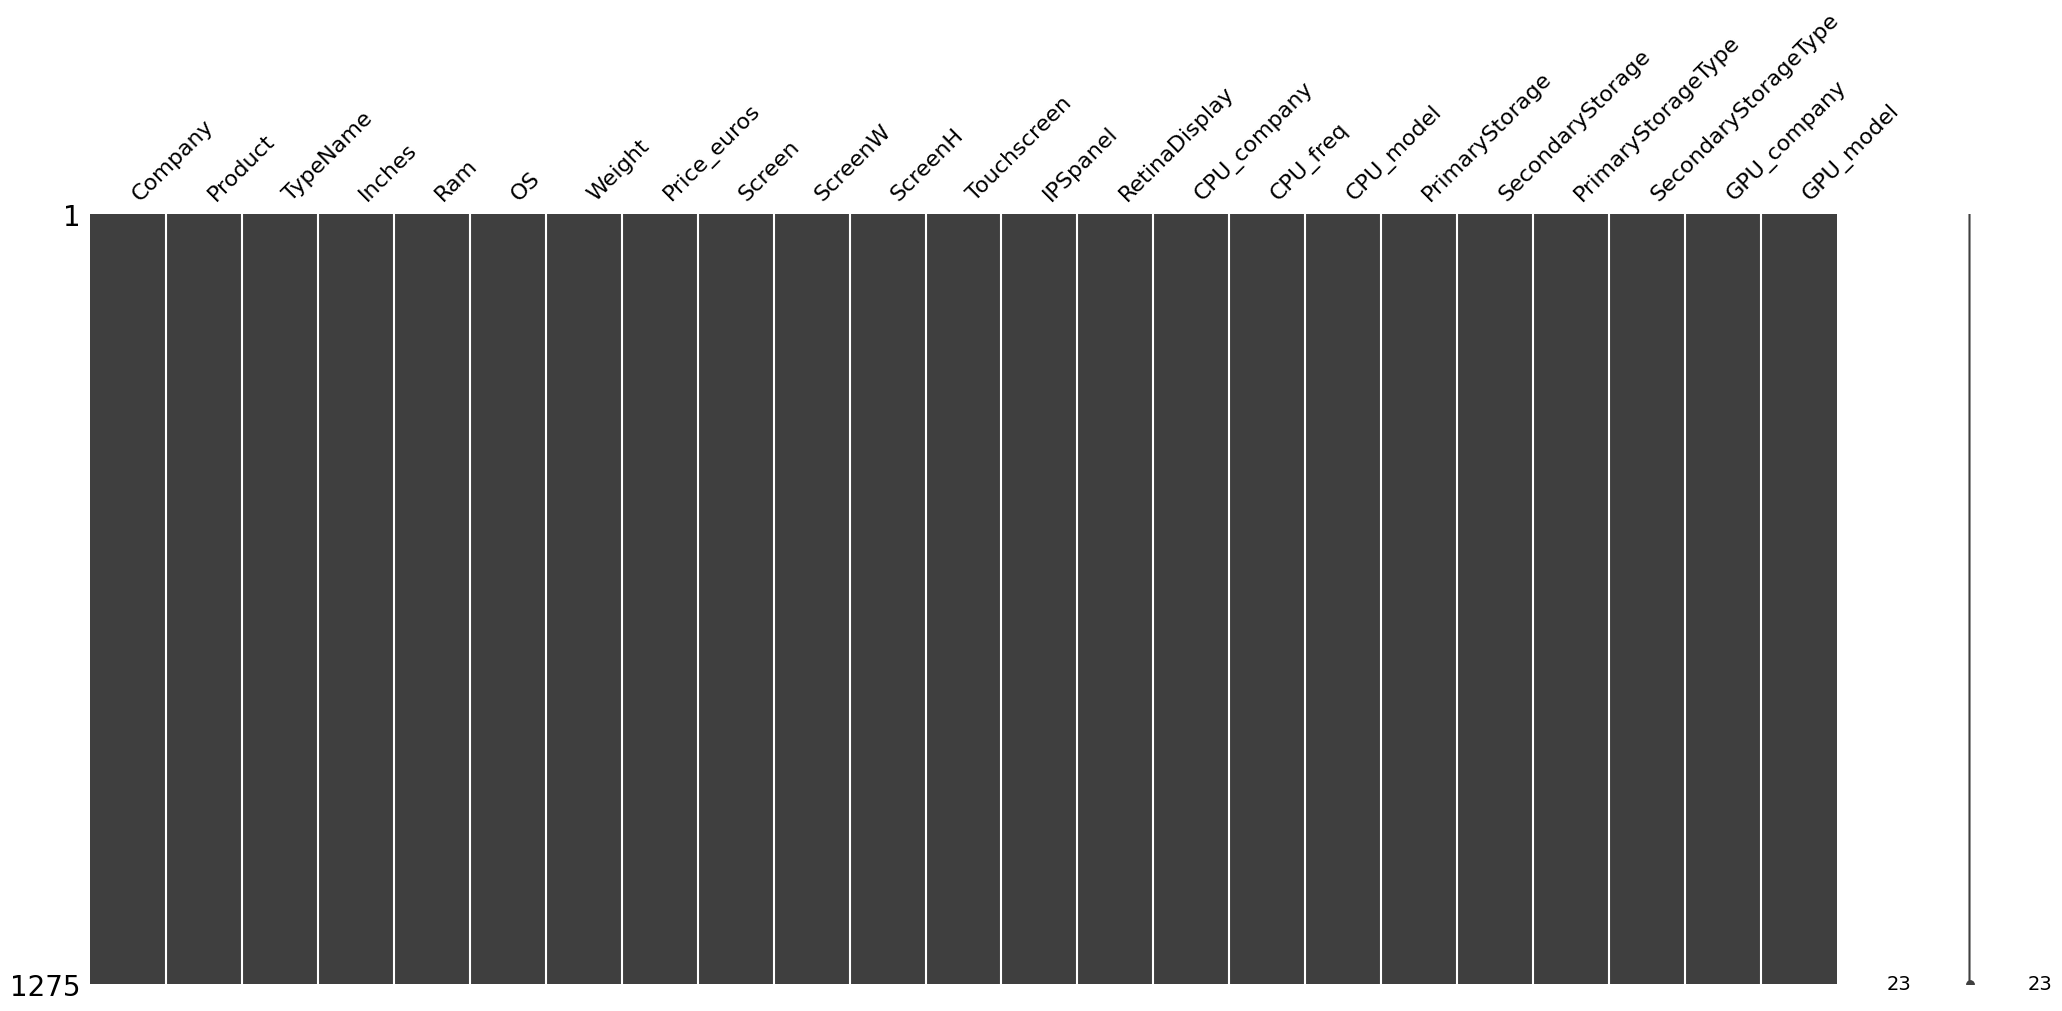

In [6]:
msno.matrix(path_df)

No duplicates in dataset

In [7]:
path_df.duplicated().sum()

np.int64(0)

### ~`Company`
Column seems to have a high cardinality between it's results due to companies having bigger market shares

Laptop companies: ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG']


C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\3828289997.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "Company",


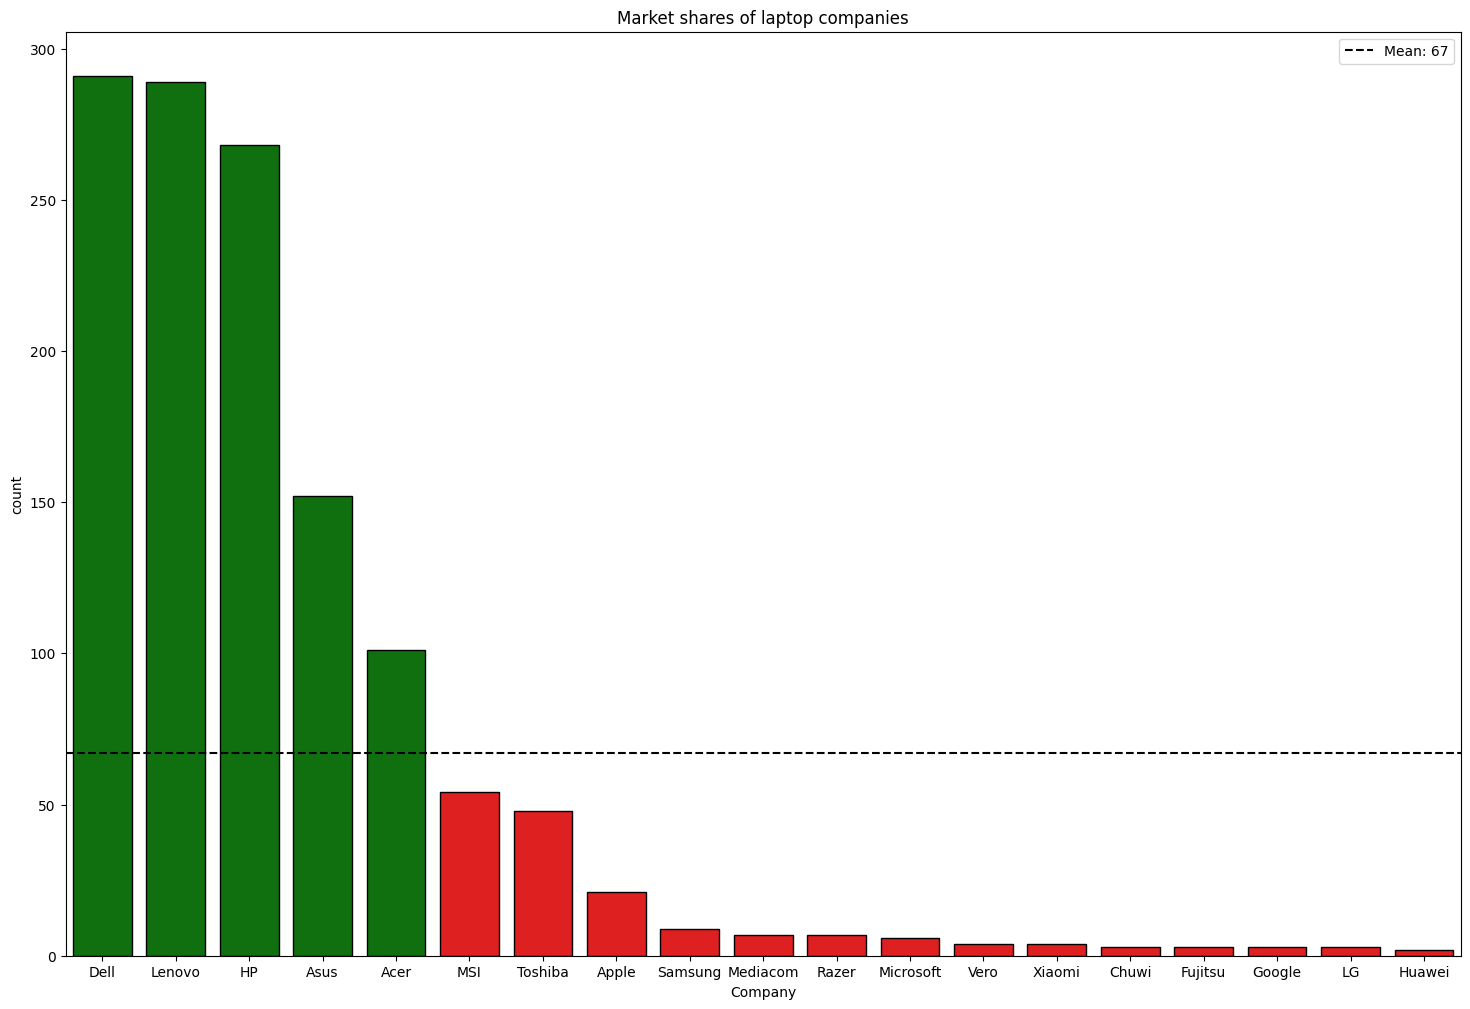

In [8]:
company_names = path_df["Company"].unique()
print(f"Laptop companies: {company_names}")

plt.figure(figsize= (18,12))

company_counts = path_df["Company"].value_counts()
avg_company_count = company_counts.mean()

# List comprehension for color condition
colors = ["green" if count >= avg_company_count else "red" for count in company_counts]

sns.countplot(x = "Company",
              data = path_df,
              order = company_counts.index,
              palette = colors,
              edgecolor = "black")
plt.title("Market shares of laptop companies")
# Average count line
plt.axhline(y = avg_company_count,
            color = "black",
            linestyle = "--",
            label = f"Mean: {avg_company_count:.0f}")
plt.legend()
plt.show()

### `Product`
Column has repeated entries (nothing concerning)

In [9]:
path_df["Product"].nunique()

618

### ~`TypeName`
**Notebooks** seem to be the most popular

Laptop types: 6


C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\2612163945.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "TypeName",


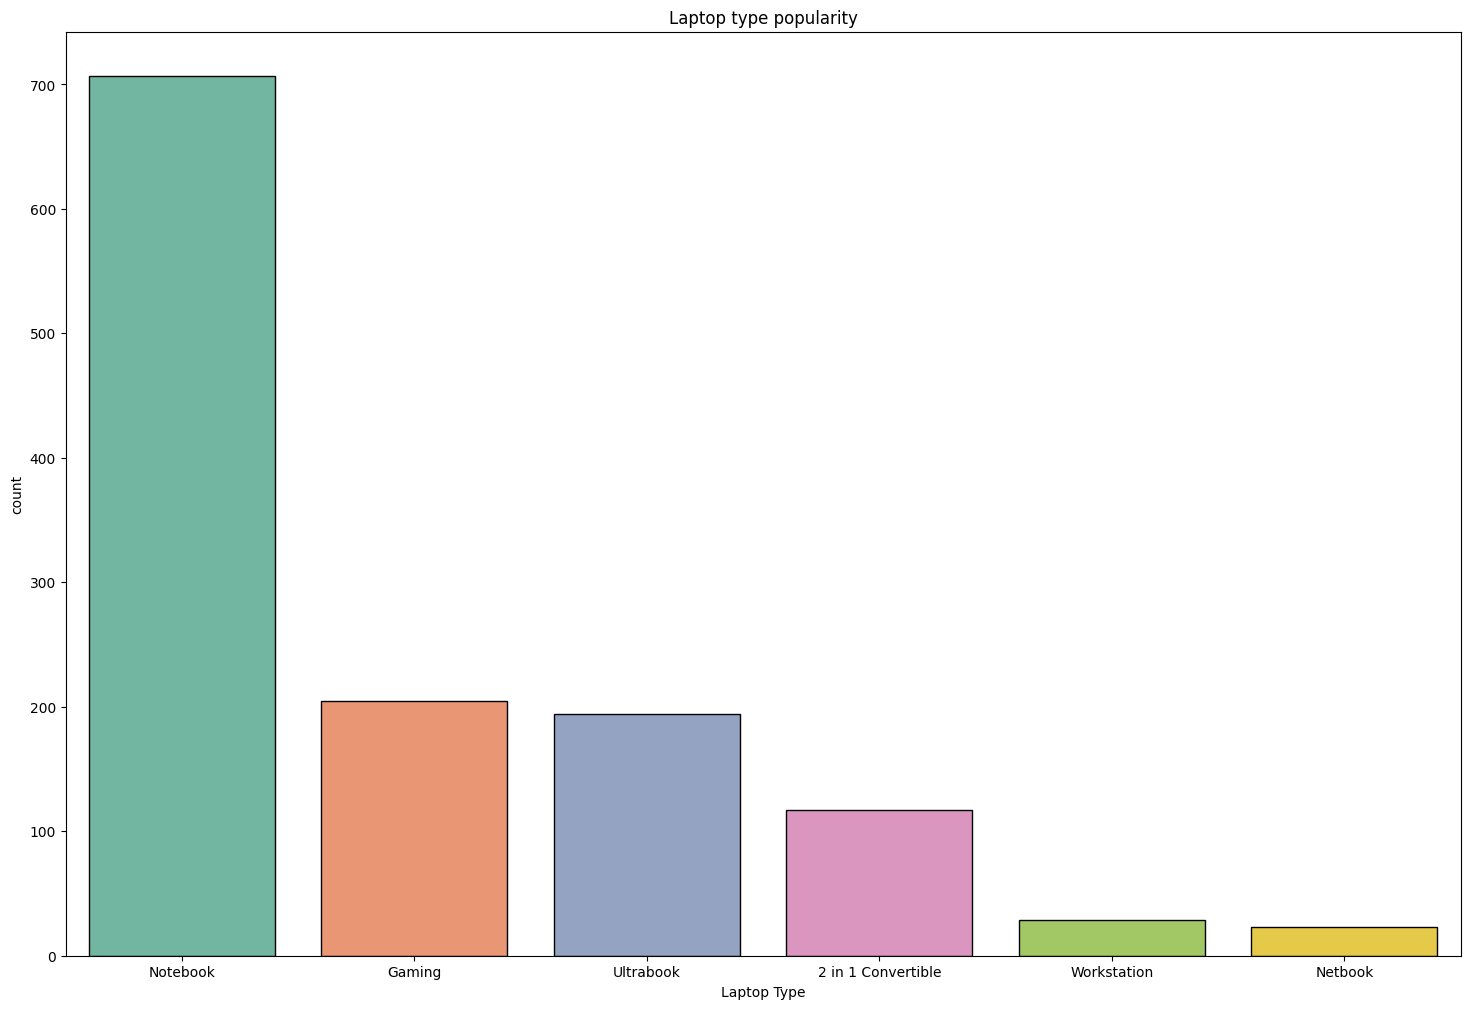

In [10]:
unique_types = path_df["TypeName"].nunique()
print(f"Laptop types: {unique_types}")

plt.figure(figsize = (18,12))

typecounts = path_df["TypeName"].value_counts()

sns.countplot(x = "TypeName",
              data = path_df,
              palette = "Set2",
              edgecolor = "black",
              order = typecounts.index)
plt.title("Laptop type popularity")
plt.xlabel("Laptop Type")
plt.show()

### `Inches`
Column seemed to have multiple high leverage points that after a deep research it was concluded that they weren't outliers. They were small sized due to them mostly being convertibles or small netbooks

Average laptop size: 15 inches
Number of outliers: 37
Outlier bounds: [11.60, 18.00]


,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
20,Asus,Vivobook E200HA,Netbook,11.6,2,Windows 10,0.98,191.90,Standard,1366,...,No,Intel,1.44,Atom x5-Z8350,32,0,Flash Storage,No,Intel,HD Graphics 400
50,Lenovo,Yoga Book,2 in 1 Convertible,10.1,4,Android,0.69,319.00,Standard,1920,...,No,Intel,1.44,Atom x5-Z8550,64,0,Flash Storage,No,Intel,HD Graphics 400
177,MSI,GT80S 6QF-074US,Gaming,18.4,32,Windows 10,4.40,2799.00,Full HD,1920,...,No,Intel,2.90,Core i7 6920HQ,512,1024,SSD,HDD,Nvidia,GTX 980 SLI
314,Asus,VivoBook Flip,2 in 1 Convertible,11.6,2,Windows 10,1.10,275.00,Standard,1366,...,No,Intel,1.10,Celeron Dual Core N3350,32,0,Flash Storage,No,Intel,HD Graphics 500
319,Acer,TravelMate B,Notebook,11.6,4,Windows 10,1.40,485.00,Standard,1366,...,No,Intel,1.60,Pentium Quad Core N3710,128,0,Flash Storage,No,Intel,HD Graphics 405
348,Asus,VivoBook Flip,2 in 1 Convertible,11.6,4,Windows 10,1.50,375.00,Standard,1366,...,No,Intel,1.10,Celeron Dual Core N3350,32,0,Flash Storage,No,Intel,HD Graphics 500
376,Lenovo,Yoga 11e,Netbook,11.6,4,Windows 10,1.59,553.00,Standard,1366,...,No,Intel,1.10,Celeron Quad Core N3450,128,0,SSD,No,Intel,HD Graphics 500
409,Lenovo,Lenovo IdeaPad,Notebook,11.6,2,Windows 10,1.15,304.45,Standard,1366,...,No,Intel,1.10,Celeron Dual Core N3350,32,0,Flash Storage,No,Intel,HD Graphics 500
429,Mediacom,FlexBook Edge,2 in 1 Convertible,11.6,4,Windows 10,1.16,299.00,Full HD,1920,...,No,Intel,1.10,Celeron Dual Core N3350,32,0,SSD,No,Intel,HD Graphics 500
430,Samsung,Chromebook 3,Netbook,11.6,4,Chrome OS,1.15,269.00,Standard,1366,...,No,Intel,1.60,Celeron Dual Core N3060,16,0,Flash Storage,No,Intel,HD Graphics 400


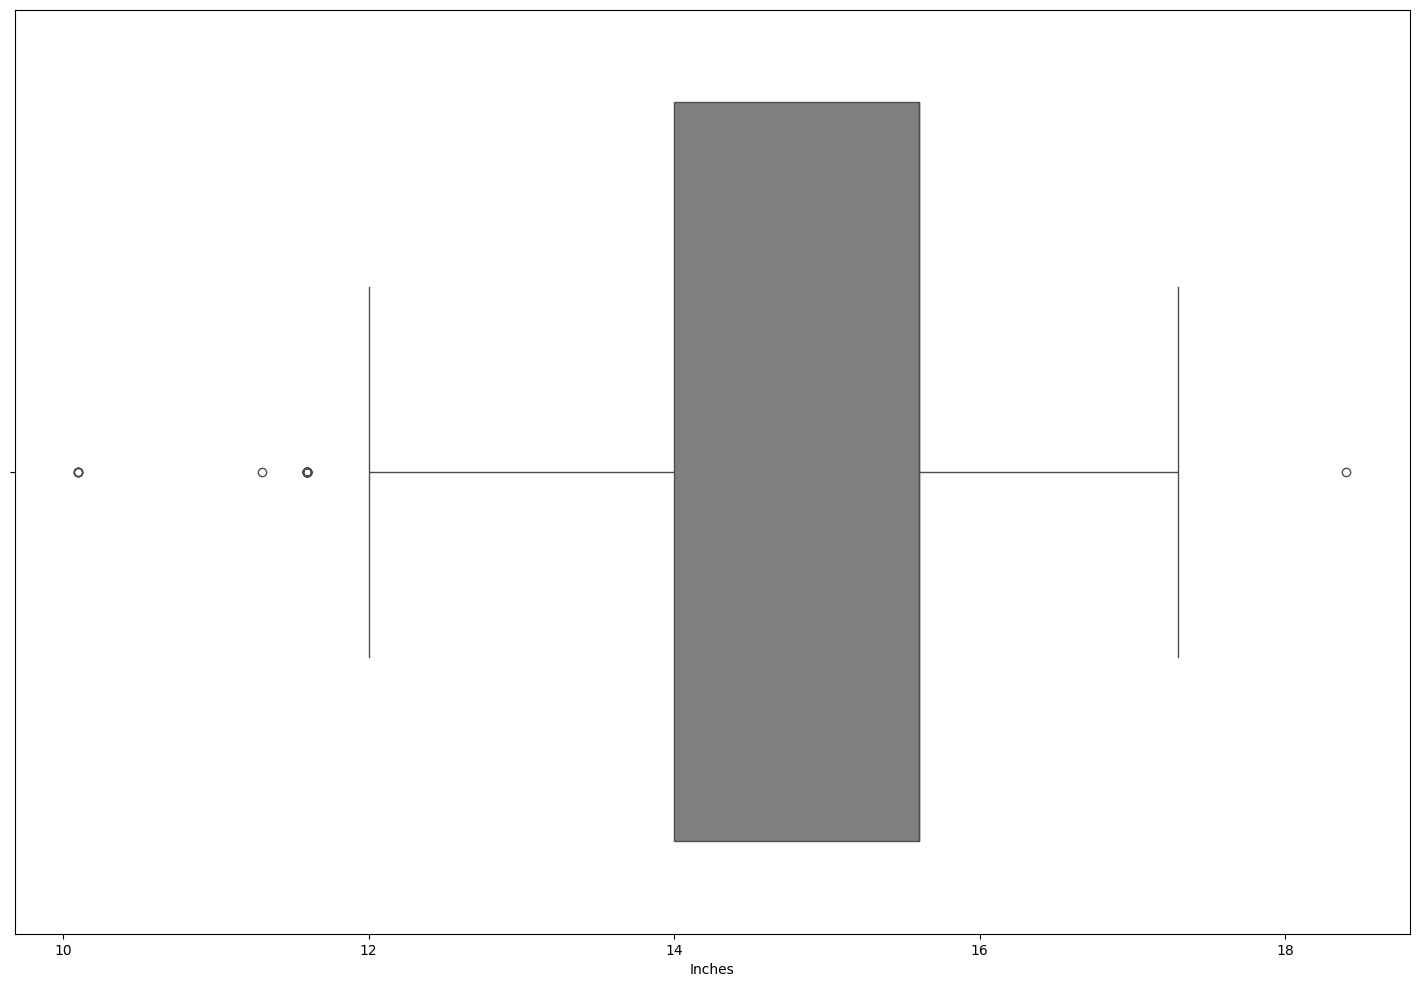

In [11]:
avg_size = path_df["Inches"].mean()
print(f"Average laptop size: {avg_size:.0f} inches")

Q1 = path_df["Inches"].quantile(0.25)
Q3 = path_df["Inches"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = path_df[(path_df["Inches"] < lower) | (path_df["Inches"] > upper)]
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier bounds: [{lower:.2f}, {upper:.2f}]")
display(outliers)

plt.figure(figsize = (18,12))
sns.boxplot(x = "Inches",
            data = path_df,
            color = "grey")
plt.show()

### `Ram`
Just like last column. `Ram` Also had high leverage points in terms of ram capacity beihng above the average in some cases. That was due to these laptops being a high performance **gaming** or **workstation** laptops

Average laptop ram: 8 GB
Number of outliers: 219
Outlier bounds: [-2.00, 14.00]


,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
6,Apple,MacBook Pro,Ultrabook,15.4,16,Mac OS X,2.04,2139.97,Standard,2880,...,Yes,Intel,2.2,Core i7,256,0,Flash Storage,No,Intel,Iris Pro Graphics
8,Asus,ZenBook UX430UN,Ultrabook,14.0,16,Windows 10,1.30,1495.00,Full HD,1920,...,No,Intel,1.8,Core i7 8550U,512,0,SSD,No,Nvidia,GeForce MX150
12,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2439.97,Standard,2880,...,Yes,Intel,2.8,Core i7,256,0,SSD,No,AMD,Radeon Pro 555
17,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2858.00,Standard,2880,...,Yes,Intel,2.9,Core i7,512,0,SSD,No,AMD,Radeon Pro 560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,Dell,Inspiron 7779,2 in 1 Convertible,17.3,16,Windows 10,2.77,1799.00,Full HD,1920,...,No,Intel,2.7,Core i7 7500U,512,0,SSD,No,Nvidia,GeForce 940MX
1245,Asus,Rog GL553VE-FY052T,Gaming,15.6,16,Windows 10,2.50,1600.00,Full HD,1920,...,No,Intel,2.8,Core i7 7700HQ,256,1024,SSD,HDD,Nvidia,GeForce GTX 1050 Ti
1247,Asus,Rog GL502VS,Gaming,15.6,16,Windows 10,2.34,2325.00,Full HD,1920,...,No,Intel,2.6,Core i7 6700HQ,256,1024,SSD,HDD,Nvidia,GeForce GTX 1070
1256,Asus,Rog G752VT-GC073T,Gaming,17.3,16,Windows 10,4.00,1900.00,Full HD,1920,...,No,Intel,2.6,Core i7 6700HQ,128,1024,SSD,HDD,Nvidia,GeForce GTX 970M


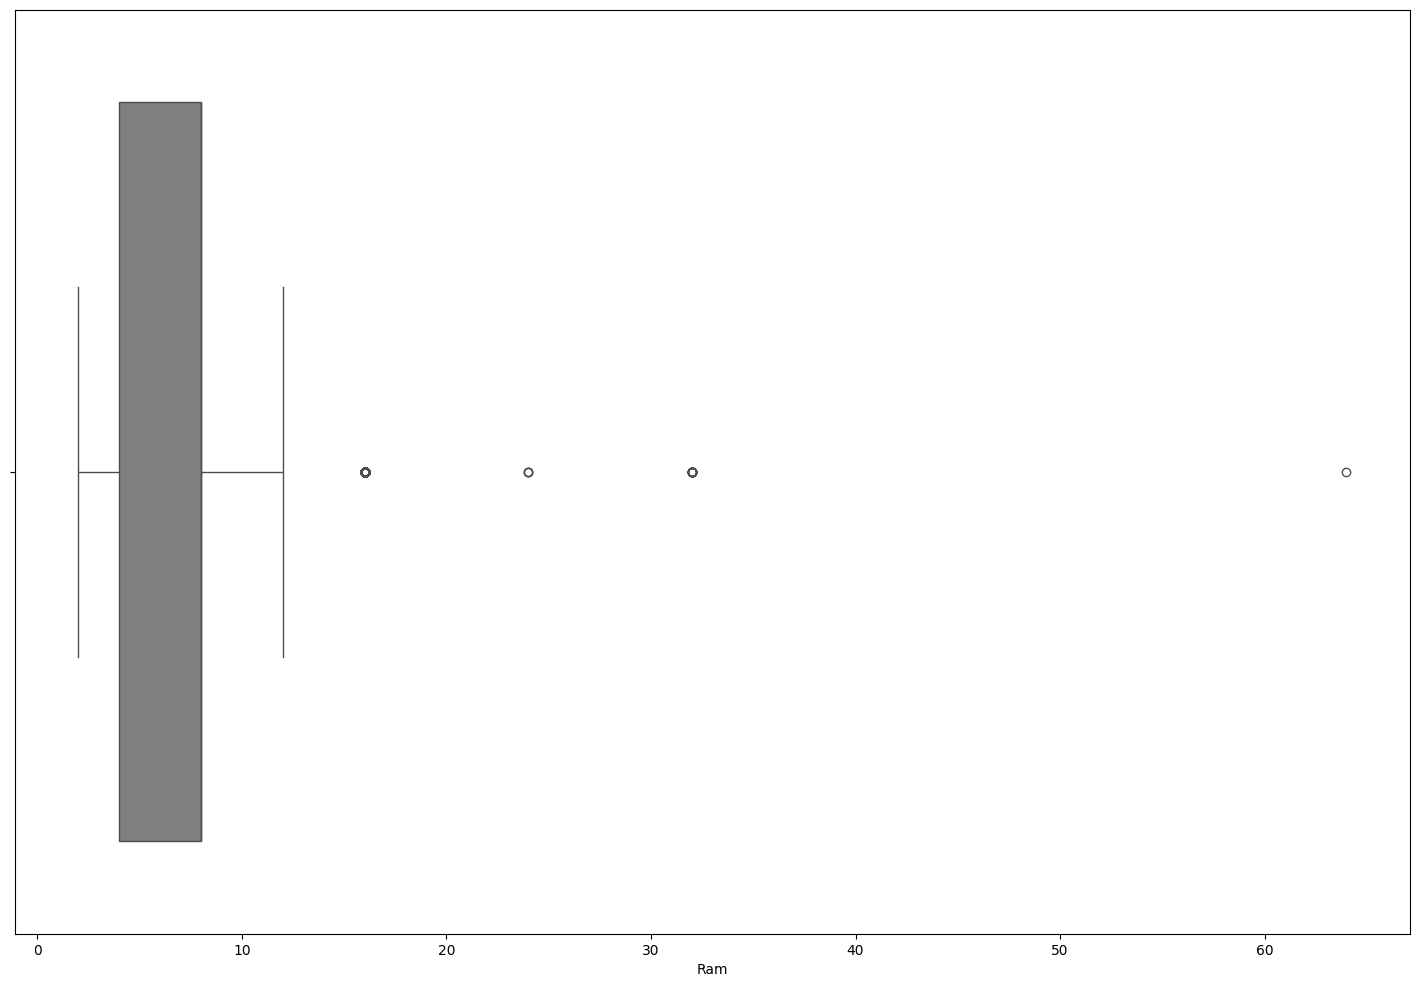

In [12]:
avg_ram = path_df["Ram"].mean()
print(f"Average laptop ram: {avg_ram:.0f} GB")

Q1 = path_df["Ram"].quantile(0.25)
Q3 = path_df["Ram"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = path_df[(path_df["Ram"] < lower) | (path_df["Ram"] > upper)]
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier bounds: [{lower:.2f}, {upper:.2f}]")
display(outliers)

plt.figure(figsize = (18,12))
sns.boxplot(x = "Ram",
            data = path_df,
            color = "grey")
plt.show()

### ~`OS`
We see high cardinality of categorical variables with a large dominance of windows 10 being the main OS for most laptops

There are a total of 9 operating systems in the market


C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\1422710124.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "OS",


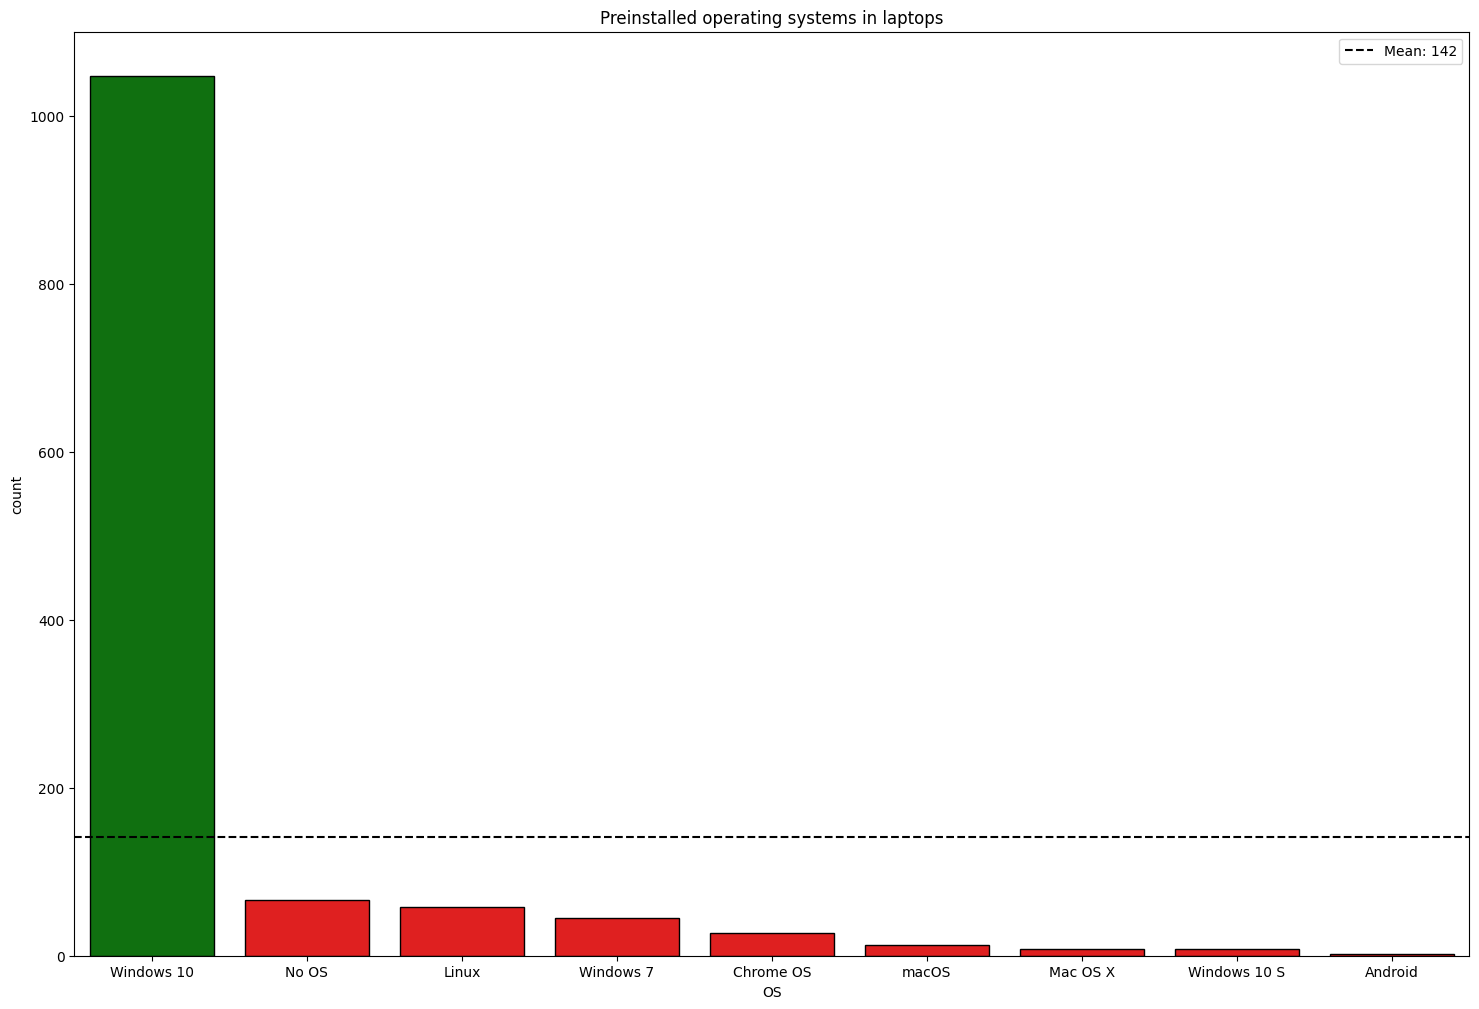

In [13]:
os_counts = path_df["OS"].value_counts()
os_avg = os_counts.mean()
os_num = path_df["OS"].nunique()
print(f"There are a total of {os_num} operating systems in the market")

color = ["green" if count > os_avg else "red" for count in os_counts]

plt.figure(figsize = (18,12))
sns.countplot(x = "OS",
              data = path_df,
              palette = color,
              order = os_counts.index,
              edgecolor = "black")
plt.axhline(y = os_avg,
            color = "black",
            linestyle = "--",
            label = f"Mean: {os_avg:.0f}")
plt.legend()
plt.title("Preinstalled operating systems in laptops")
plt.show()

### `Weight`
There seems to be a couple influencial entires where they weigh more than 2.71 KG but it's to be expected due to their bigger surface area compared to other laptops

Average weight: 2.04 KG
Number of outliers: 45
Outlier bounds: [0.28, 3.53]


,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
177,MSI,GT80S 6QF-074US,Gaming,18.4,32,Windows 10,4.40,2799.00,Full HD,1920,...,No,Intel,2.9,Core i7 6920HQ,512,1024,SSD,HDD,Nvidia,GTX 980 SLI
224,Dell,Alienware 17,Gaming,17.3,16,Windows 10,4.42,2456.34,Full HD,1920,...,No,Intel,2.8,Core i7 7700HQ,256,1024,SSD,HDD,Nvidia,GeForce GTX 1060
238,Asus,ROG G703VI-E5062T,Gaming,17.3,32,Windows 10,4.70,3890.00,Full HD,1920,...,No,Intel,2.9,Core i7 7820HK,512,1024,SSD,HDD,Nvidia,GeForce GTX 1080
247,Asus,Rog G701VIK-BA060T,Gaming,17.3,16,Windows 10,3.60,2999.00,Full HD,1920,...,No,Intel,2.9,Core i7 7820HK,256,0,SSD,No,Nvidia,GeForce GTX 1080
251,Asus,ROG G752VSK-GC493T,Gaming,17.3,16,Windows 10,4.30,1799.00,Full HD,1920,...,No,Intel,2.8,Core i7 7700HQ,256,1024,SSD,HDD,Nvidia,GeForce GTX 980M
258,MSI,GT73EVR 7RE,Gaming,17.3,16,Windows 10,4.14,2499.00,Full HD,1920,...,No,Intel,2.8,Core i7 7700HQ,512,1024,SSD,HDD,Nvidia,GeForce GTX 1070
424,Dell,Alienware 17,Gaming,17.3,16,Windows 10,4.42,2799.00,Standard,2560,...,No,Intel,2.9,Core i7 7820HK,256,1024,SSD,HDD,Nvidia,GeForce GTX 1070
456,Dell,Alienware 17,Notebook,17.3,8,Windows 10,4.42,2046.00,Full HD,1920,...,No,Intel,2.7,Core i7 7700HQ,1024,0,HDD,No,Nvidia,GeForce GTX 1060
468,HP,Omen 17-an006nv,Gaming,17.3,12,Windows 10,3.78,1699.00,Full HD,1920,...,No,Intel,2.8,Core i7 7700HQ,1024,0,HDD,No,Nvidia,GeForce GTX 1060
494,Asus,Rog G752VL-UH71T,Gaming,17.3,24,Windows 10,4.33,1269.00,Full HD,1920,...,No,Intel,2.6,Core i7 6700HQ,256,1024,SSD,HDD,Nvidia,GeForce GTX 965M


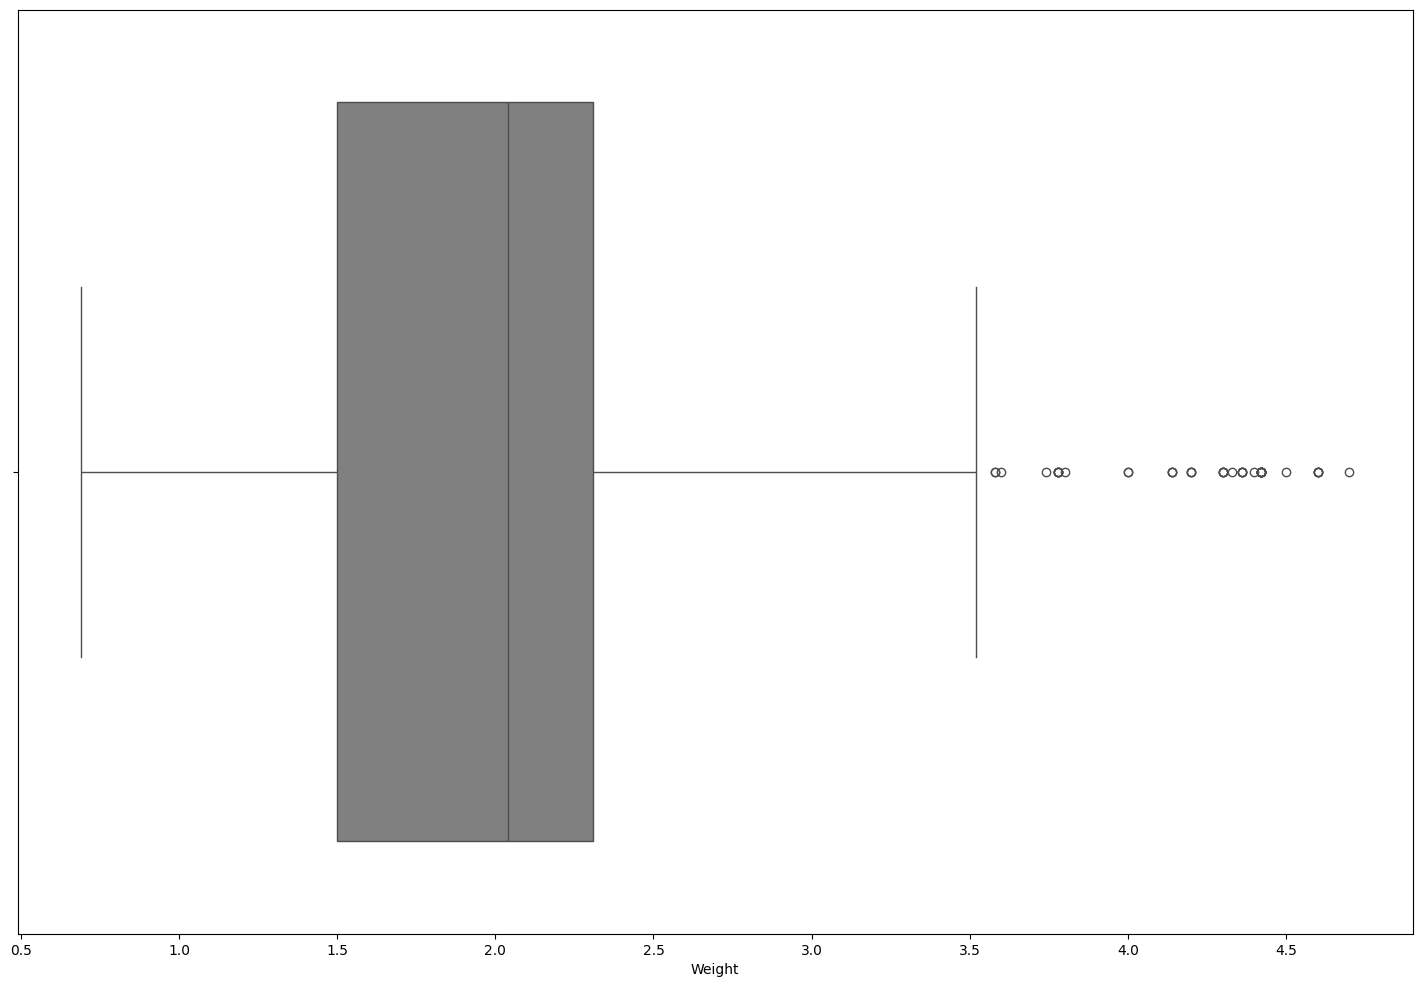

In [14]:
avg_weight = path_df["Weight"].mean()
print(f"Average weight: {avg_weight:.2f} KG")

Q1 = path_df["Weight"].quantile(0.25)
Q3 = path_df["Weight"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = path_df[(path_df["Weight"] < lower) | (path_df["Weight"] > upper)]
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier bounds: [{lower:.2f}, {upper:.2f}]")
display(outliers)

plt.figure(figsize = (18,12))
sns.boxplot(x = "Weight",
            data = path_df,
            color = "grey")
plt.show()

As we see, there's a positive linear relationship between the laptop size in inches and its weight

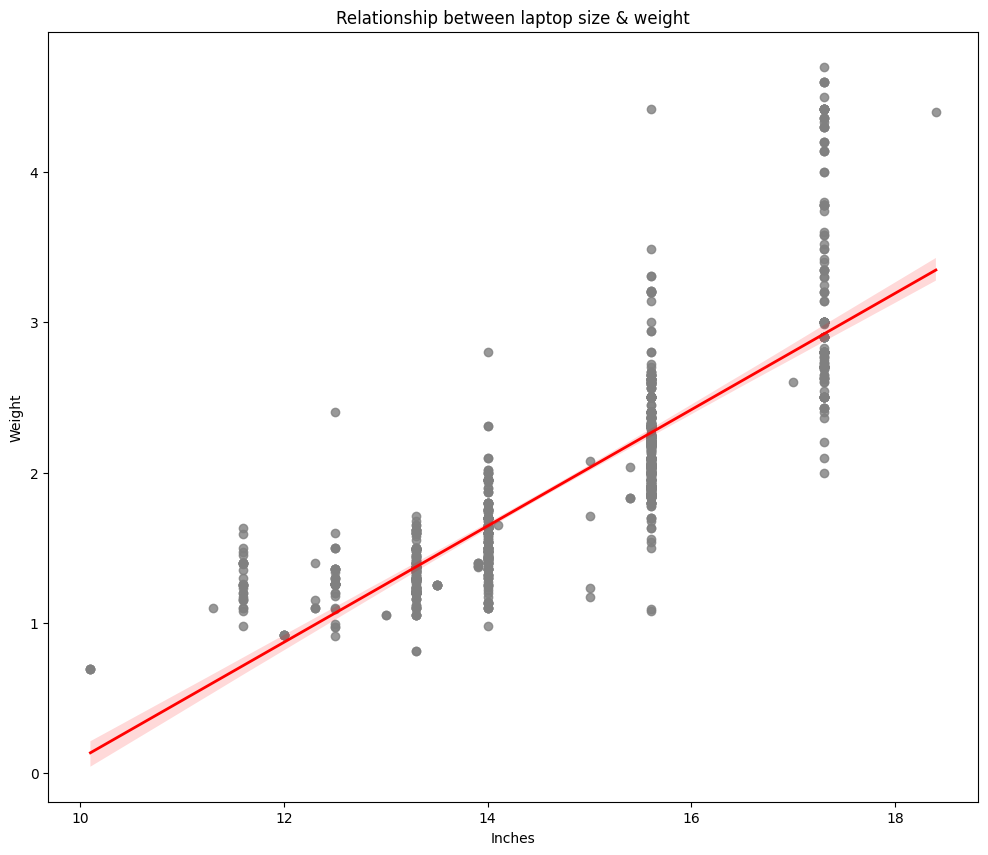

In [15]:
plt.figure(figsize = (12,10))
sns.regplot(x = "Inches",
                y = "Weight",
                data = path_df,
                scatter_kws = {"color" : "grey", "alpha" : 0.8},
                line_kws = {"color" : "red", "linewidth" : 2})
plt.title("Relationship between laptop size & weight")
plt.show()

### `Price_euros`
Price seems to be skewed which will need transformation to adjust and normalize or checking outliers

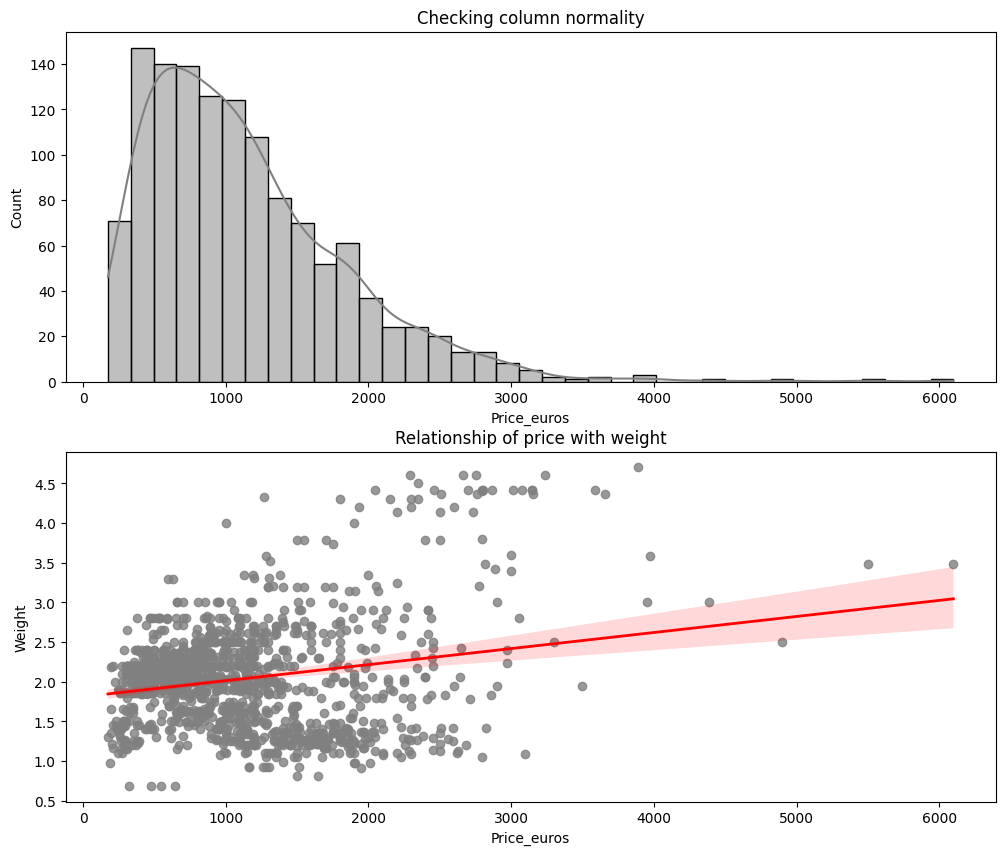

Price kurtosis before transformation: 4.34, Leptokurtic (Many Outliers)
Price skew before transformation: 1.51, Very skewed


In [16]:
def state_skew(x):
    if abs(x) > 1:
        return "Very skewed"
    elif 0.5 <= abs(x) <= 1:
        return "Moderately skewed"
    else : 
        return "Symmetrical"
def state_kurtosis(x):
    if x > 1:
        return "Leptokurtic (Many Outliers)"
    elif x < -1:
        return "Playtukurtic (Few Outliers)"
    else :
        return "Mesokurtic (Normal tails)"
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 10))
sns.histplot(x = "Price_euros",
             data = path_df,
             color = "grey",
             edgecolor = "black",
             kde = True,
             ax = ax1)
ax1.set_title("Checking column normality")
sns.regplot(x = "Price_euros",
                y = "Weight",
                data = path_df,
                scatter_kws = {"color" : "grey", "alpha" : 0.8},
                line_kws = {"color" : "red", "linewidth" : 2},
                ax = ax2)
ax2.set_title("Relationship of price with weight")
plt.show()

price_kurtosis = path_df["Price_euros"].kurtosis()
price_skew = path_df["Price_euros"].skew()
print(f"Price kurtosis before transformation: {price_kurtosis:.2f}, {state_kurtosis(price_kurtosis)}")
print(f"Price skew before transformation: {price_skew:.2f}, {state_skew(price_skew)}")

From what we can see is there are multiple outliers that could affect the modeling phase.
After further investigation they could seem dangerous but after transformation most likely it'll be completely normalized due to these highly priced laptops being either workstation, ultrabooks or gaming laptops that have alot of expensive parts

Average price: 1134.97€
Number of outliers: 156
Outlier bounds: [-722.25, 1940.25]


,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
6,Apple,MacBook Pro,Ultrabook,15.4,16,Mac OS X,2.04,2139.97,Standard,2880,...,Yes,Intel,2.2,Core i7,256,0,Flash Storage,No,Intel,Iris Pro Graphics
12,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2439.97,Standard,2880,...,Yes,Intel,2.8,Core i7,256,0,SSD,No,AMD,Radeon Pro 555
17,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2858.00,Standard,2880,...,Yes,Intel,2.9,Core i7,512,0,SSD,No,AMD,Radeon Pro 560
58,MSI,GS73VR 7RG,Gaming,17.3,16,Windows 10,2.43,2449.00,Full HD,1920,...,No,Intel,2.8,Core i7 7700HQ,256,2048,SSD,HDD,Nvidia,GeForce GTX 1070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,MSI,GS73VR Stealth,Gaming,17.3,16,Windows 10,2.43,1948.99,Full HD,1920,...,No,Intel,2.6,Core i7 6700HQ,256,1024,SSD,HDD,Nvidia,GeForce GTX 1060
1214,Asus,ROG Strix,Gaming,17.3,16,Windows 10,2.90,1949.00,Full HD,1920,...,No,Intel,2.8,Core i7 7700HQ,256,1024,SSD,HDD,Nvidia,GeForce GTX 1060
1231,Razer,Blade Pro,Gaming,14.0,16,Windows 10,1.95,3499.00,Full HD,1920,...,No,Intel,2.8,Core i7 7700HQ,1024,0,SSD,No,Nvidia,GeForce GTX 1060
1236,HP,EliteBook 840,Ultrabook,14.0,8,Windows 7,1.54,2198.19,Standard,2560,...,No,Intel,2.5,Core i7 6500U,256,0,SSD,No,Intel,HD Graphics 520


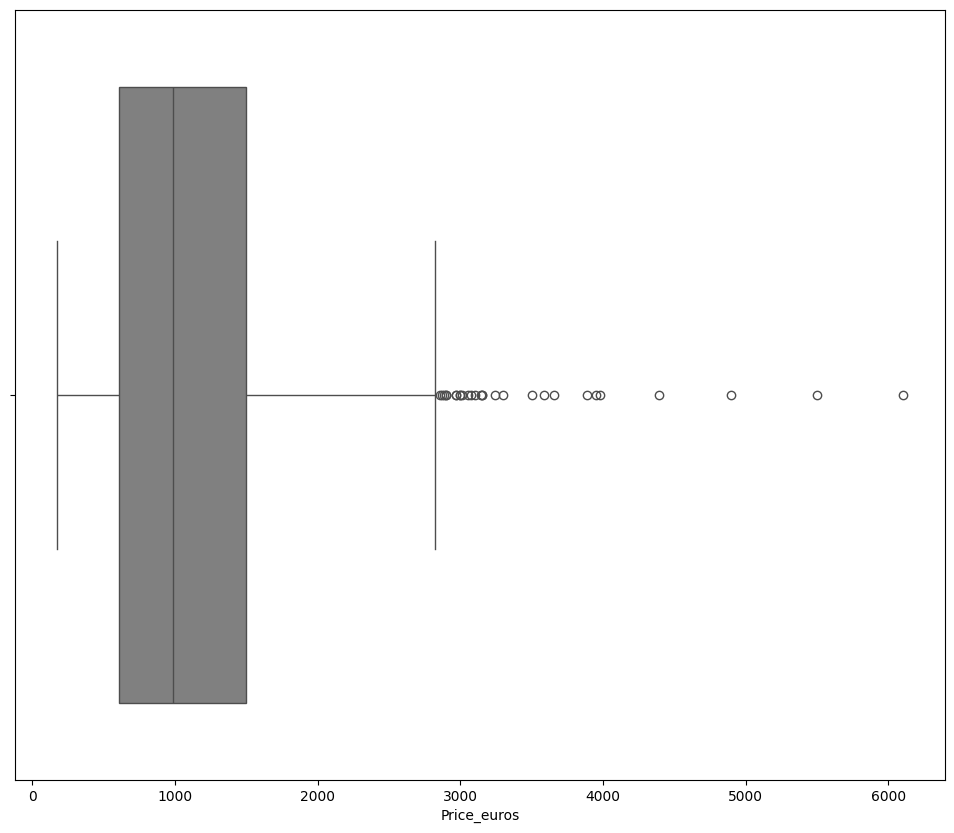

In [17]:
avg_price = path_df["Price_euros"].mean()
print(f"Average price: {avg_price:.2f}€")

Q1 = path_df["Price_euros"].quantile(0.25)
Q3 = path_df["Price_euros"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q1 + 1.5 * IQR

outliers = path_df[(path_df["Price_euros"] < lower) | (path_df["Price_euros"] > upper)]
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier bounds: [{lower:.2f}, {upper:.2f}]")
display(outliers)

plt.figure(figsize = (12, 10))
sns.boxplot(x = "Price_euros",
            data = path_df,
            color = "grey")
plt.show()

### ~`Screen`, `ScreenW`, & `ScreemH`
Dominance of **Full HD** & **Standard** over the laptop market (High Cardinality)

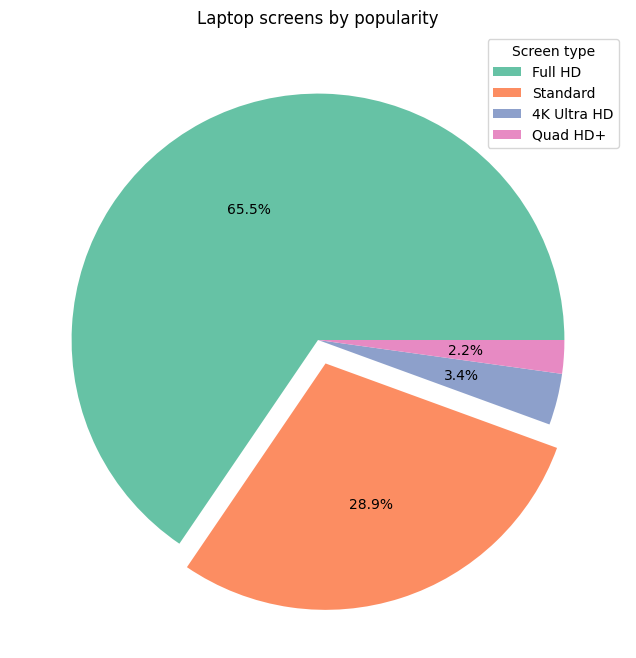

In [18]:
screen_count = path_df["Screen"].value_counts()

plt.figure(figsize = (10,8))
plt.pie(screen_count.values,
        colors = sns.color_palette("Set2"),
        autopct = "%1.1f%%",
        explode = [0, 0.1, 0, 0])  # Shows percentage
plt.title("Laptop screens by popularity")
plt.legend(labels = screen_count.index,
           title = "Screen type",
           loc = "best")
plt.show()

**1920x1080p** dominated laptop screens and to this day it's the most popular and most used resolution although **2560x1440p** & **3840x2160p** (also known as **4K**) has been getting more popular in the recent years

C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\1894321230.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "Resolution",


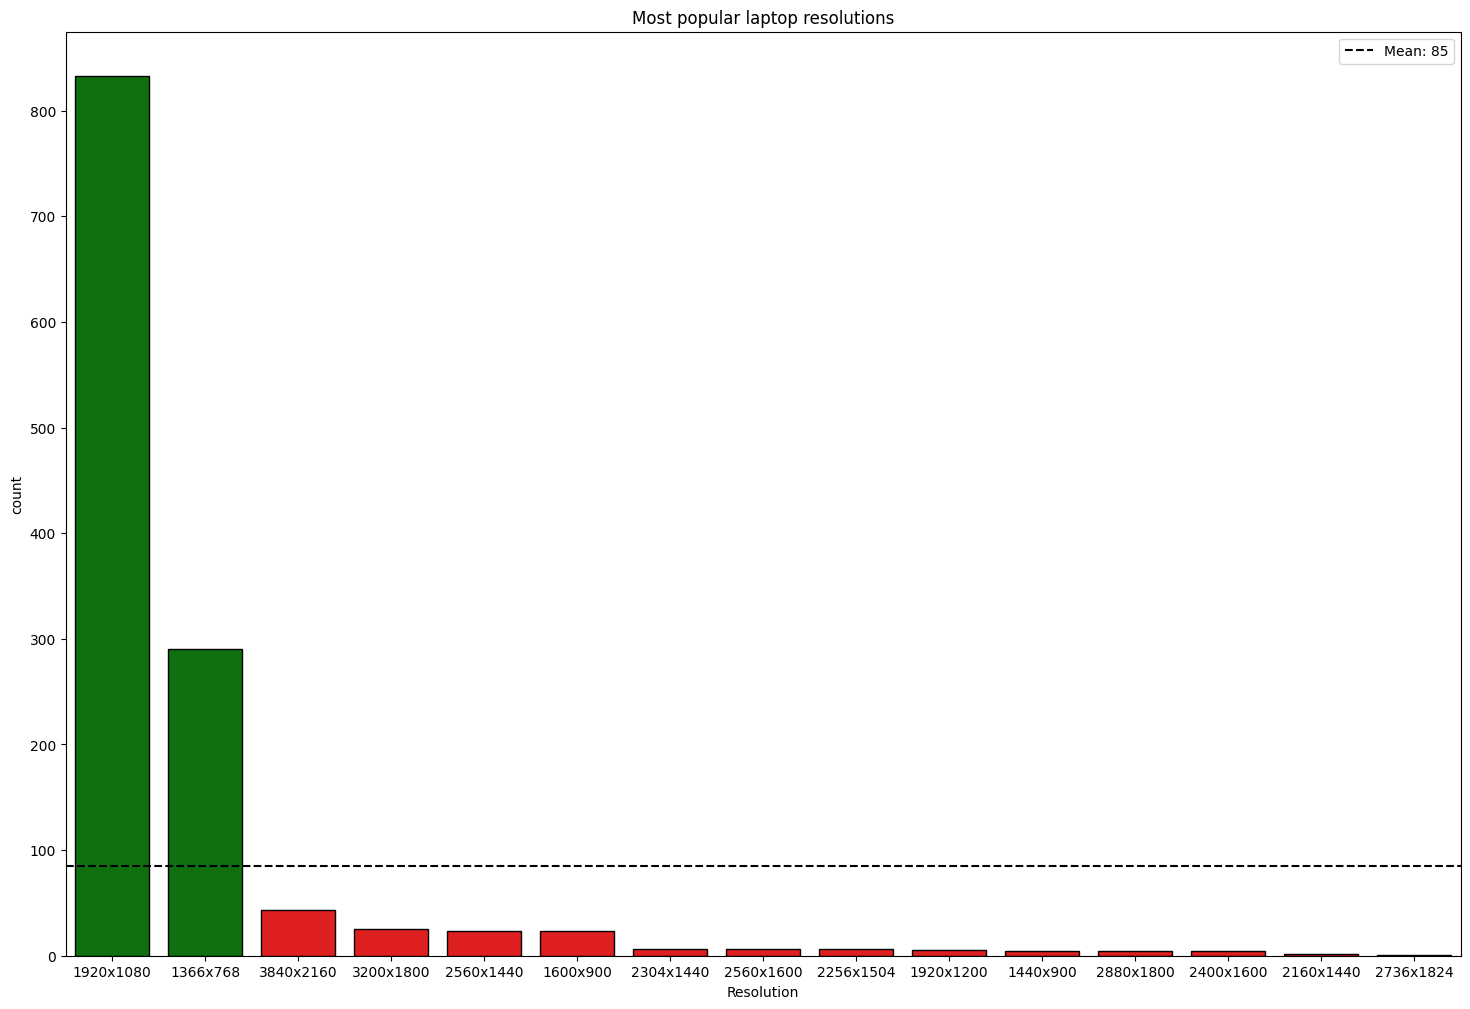

In [19]:
# Generating the full screen resolution
path_df["Resolution"] = path_df["ScreenW"].astype(str) + "x" + path_df["ScreenH"].astype(str)
res_count = path_df["Resolution"].value_counts()
avg_res = res_count.mean()

color = ["green" if count >= avg_res else "red" for count in res_count]

plt.figure(figsize = (18, 12))
sns.countplot(x = "Resolution",
              data = path_df,
              order = res_count.index,
              palette = color,
              edgecolor = "black")
plt.title("Most popular laptop resolutions")
plt.axhline(y = avg_res,
            color = "black",
            linestyle = "--",
            label = f"Mean: {avg_res:.0f}")
plt.legend()
plt.show()

### ~`Touchscreen`

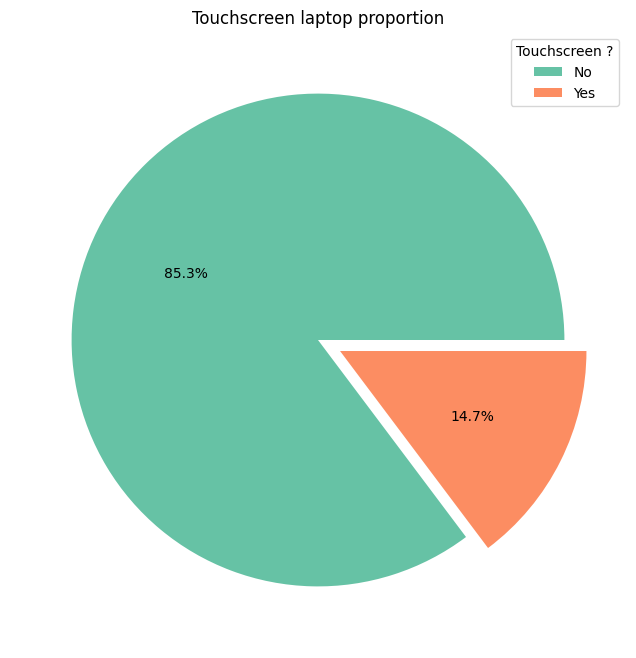

In [20]:
touch_count = path_df["Touchscreen"].value_counts()

plt.figure(figsize = (10, 8))
plt.pie(touch_count.values,
        colors = sns.color_palette("Set2"),
        autopct = "%1.1f%%",
        explode = [0, 0.1])
plt.title("Touchscreen laptop proportion")
plt.legend(labels = touch_count.index,
           title = "Touchscreen ?",
           loc = "best")

### ~`IPSpanel`

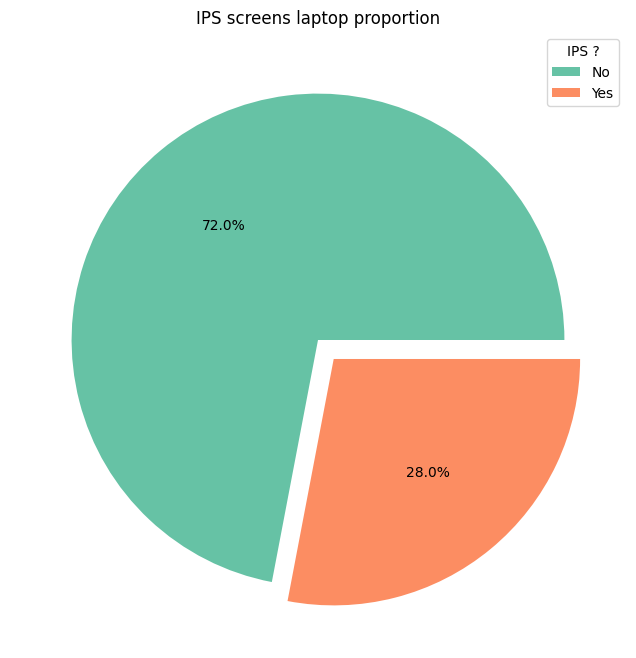

In [21]:
ips_count = path_df["IPSpanel"].value_counts()

plt.figure(figsize = (10, 8))
plt.pie(ips_count.values,
        colors = sns.color_palette("Set2"),
        autopct = "%1.1f%%",
        explode = [0, 0.1])
plt.title("IPS screens laptop proportion")
plt.legend(labels = ips_count.index,
           title = "IPS ?",
           loc = "best")

### ~`RetinaDisplay`
Very little laptops had retina display screens where this technology was mostly unique to apple macbooks

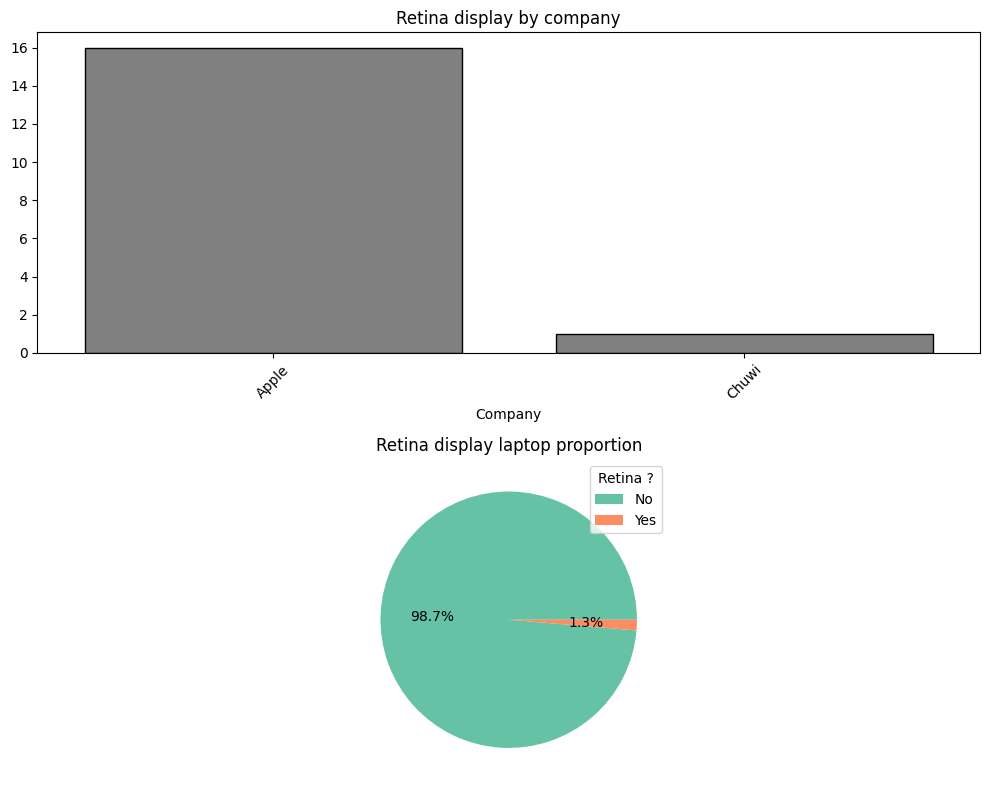

Only 2 companies have retina display laptops
Total Retina laptops: 17 (1.3%)


C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\227753589.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Total Retina laptops: {retina_count.get(1, 0)} ({retina_count.get(1, 0)/len(path_df)*100:.1f}%)")


In [22]:
retina_count = path_df["RetinaDisplay"].value_counts()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,8))
ax2.pie(retina_count.values,
        colors = sns.color_palette("Set2"),
        autopct = "%1.1f%%")
ax2.legend(labels = retina_count.index,
           title = "Retina ?",
           loc = "upper right")
ax2.set_title("Retina display laptop proportion")

# Showing only companies making retina display laptops
retina_by_company = path_df[path_df["RetinaDisplay"] == "Yes"].groupby("Company")["RetinaDisplay"].count().sort_values(ascending = False)
retina_companies = retina_by_company[retina_by_company > 0]

sns.barplot(x = retina_companies.index,
            y = retina_companies.values,
            color = "grey",
            edgecolor = "black",
            ax = ax1)
ax1.set_title("Retina display by company")
ax1.tick_params(axis = "x", rotation = 45)
plt.tight_layout()
plt.show()

print(f"Only {retina_companies.shape[0]} companies have retina display laptops")
print(f"Total Retina laptops: {retina_count.get(1, 0)} ({retina_count.get(1, 0)/len(path_df)*100:.1f}%)")

### ~`CPU_company`
Intel holds a massive market share in CPUs for laptops

C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\4141505691.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "CPU_company",


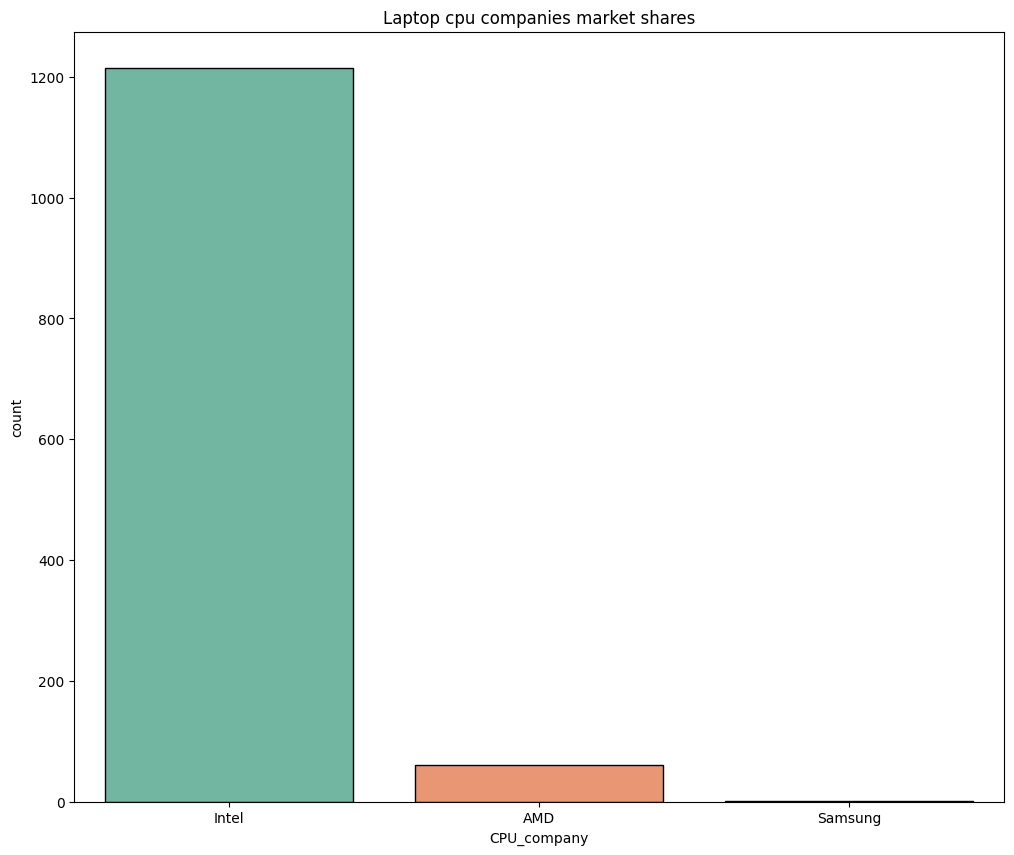

In [23]:
plt.figure(figsize = (12, 10))
sns.countplot(x = "CPU_company",
              data = path_df,
              palette = "Set2",
              edgecolor = "black")
plt.title("Laptop cpu companies market shares")
plt.show()

### `CPU_freq`
Although **Intel** holds the bigger marketshare. **AMD** seems to have the better performing CPUs on average

C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\3676032940.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = cpu_company_freq.index,


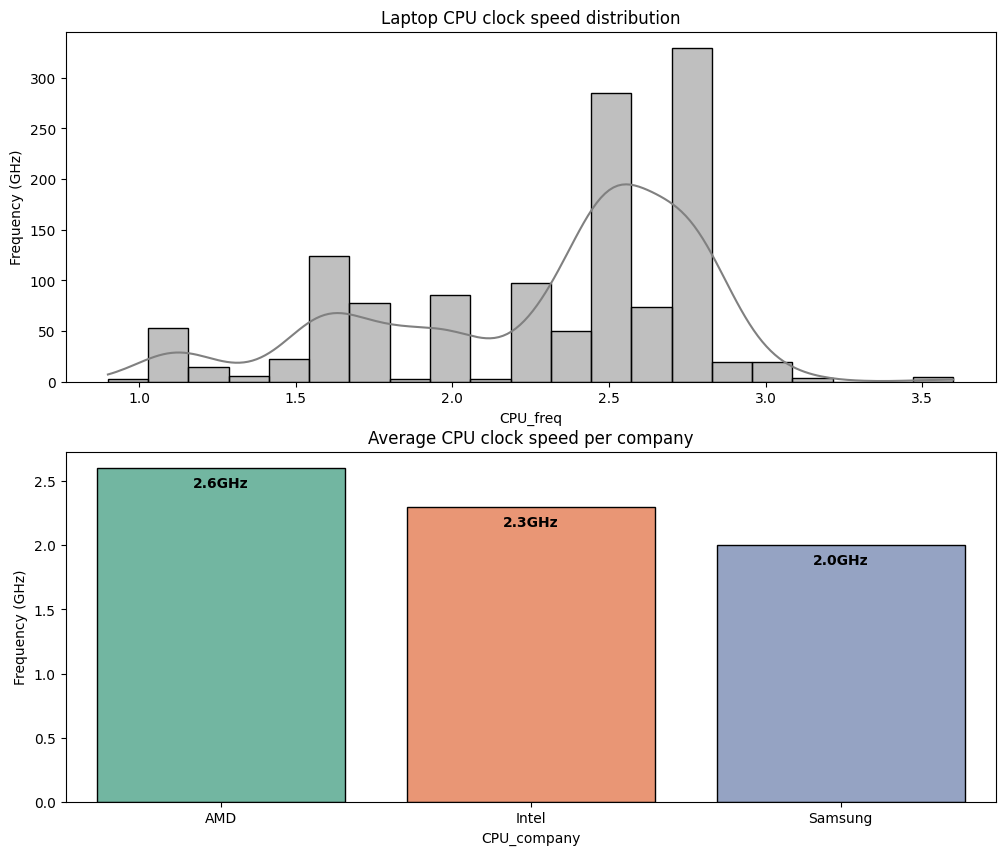

In [24]:
cpu_company_freq = path_df.groupby("CPU_company")["CPU_freq"].mean().sort_values(ascending = False).round(1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 10))
sns.histplot(x = "CPU_freq",
             data = path_df,
             color = "grey",
             edgecolor = "black",
             kde = True,
             ax = ax1)
ax1.set_title("Laptop CPU clock speed distribution")
ax1.set_ylabel("Frequency (GHz)")

sns.barplot(x = cpu_company_freq.index,
            y = cpu_company_freq.values,
            palette = "Set2",
            edgecolor = "black",
            ax = ax2)
ax2.set_title("Average CPU clock speed per company")
ax2.set_ylabel("Frequency (GHz)")
for i, v in enumerate(cpu_company_freq.values):
    ax2.text(i, v - 0.15, f"{v:.1f}GHz", ha = "center", fontweight = "bold")
plt.show()

### ~`CPU_model`
There is a massive popularity of "**Core i**" models compared to other models of **Intel** and other CPU companies (High Cardinality)

C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\137131342.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "CPU_series",


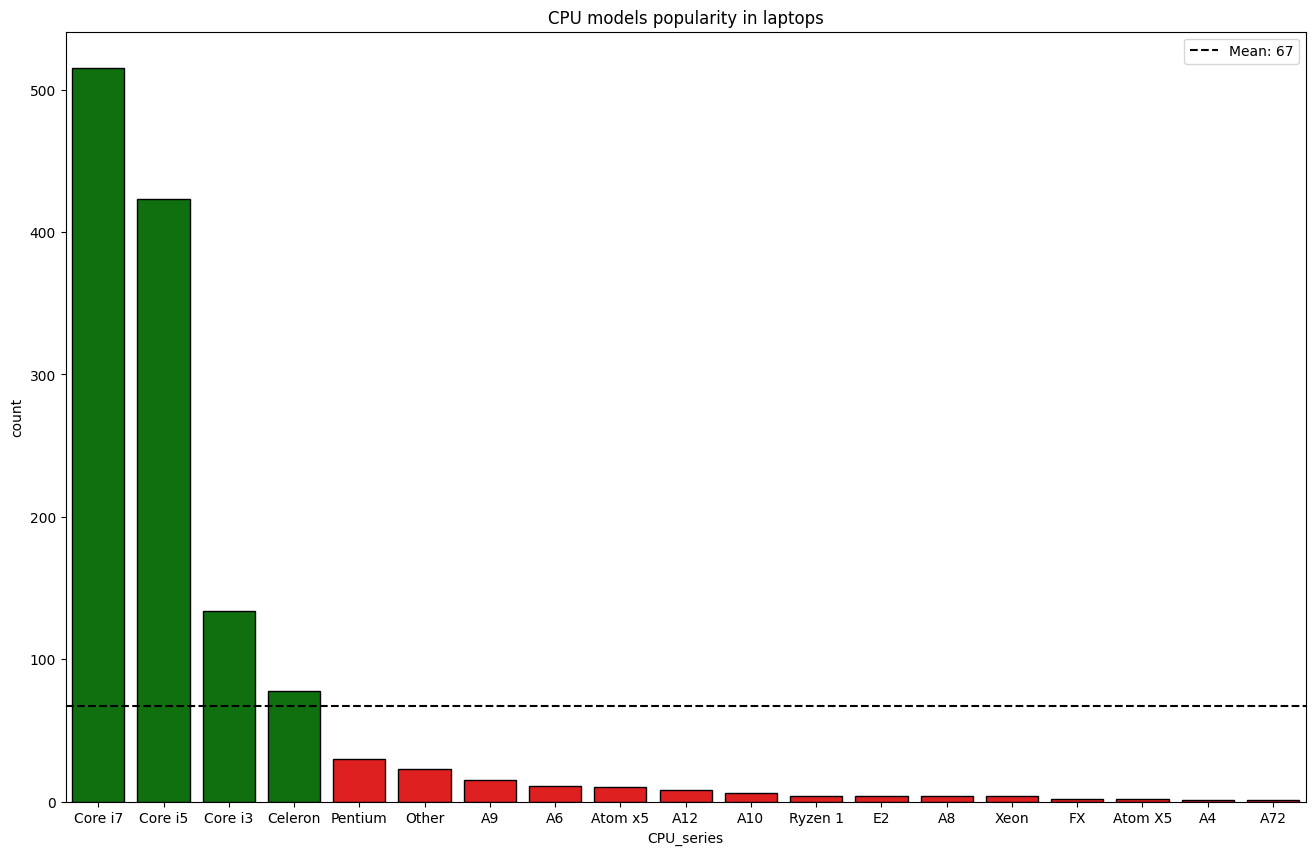

In [25]:
# Extracting 
def extract_cpu_model(cpu_string):
    patterns = [
        r'(Core [im]\d)',           # Core i3, i5, i7, i9, m3, m5, etc...
        r'(Ryzen \d)',              # Ryzen 3, 5, 7
        r'(Atom [xX]\d)',           # Atom x5, x7
        r'(Celeron)',               # Celeron
        r'(Pentium)',               # Pentium
        r'(Xeon)',                  # Xeon
        r'(A\d+)',                  # AMD A6, A9, A10, A12, etc...
        r'(E2)',                    # AMD E2
        r'(FX)',                    # AMD FX
    ]
    
    for pattern in patterns:
        match = re.search(pattern, cpu_string, re.IGNORECASE)
        if match:
            return match.group(1)
    return "Other"

path_df["CPU_series"] = path_df["CPU_model"].apply(extract_cpu_model)
series_counts = path_df["CPU_series"].value_counts()
avg_series = series_counts.mean()

colors = ["green" if count > avg_series else "red" for count in series_counts]

plt.figure(figsize = (16,10))
sns.countplot(x = "CPU_series",
              data = path_df,
              palette = colors,
              order = series_counts.index,
              edgecolor = "black")
plt.axhline(y = avg_series,
            color = "black",
            linestyle = "--",
            label =f"Mean: {avg_series:.0f}")
plt.legend()
plt.title("CPU models popularity in laptops")
plt.show()

### `PrimaryStorage`
Most laptops had **256GBs** as a primary drive that had their operating system on

C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\2473541012.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "PrimaryStorage",


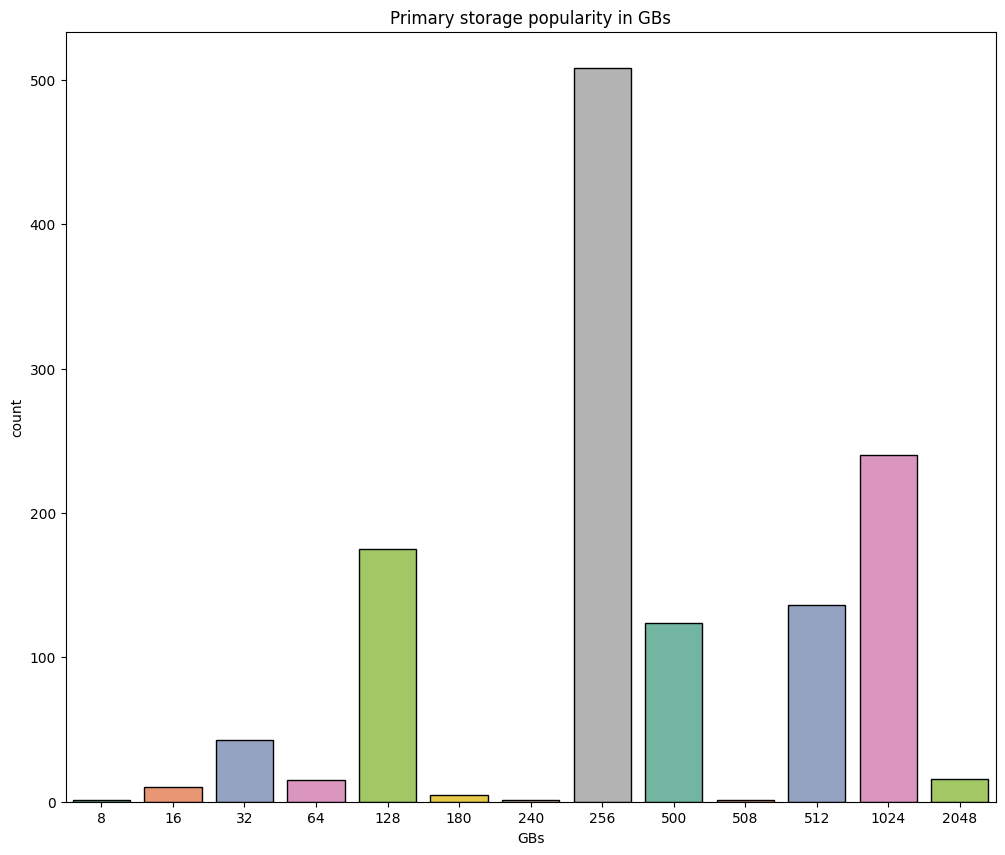

In [26]:
plt.figure(figsize = (12,10))
sns.countplot(x = "PrimaryStorage",
              data = path_df,
              palette = "Set2",
              edgecolor = "black")
plt.title("Primary storage popularity in GBs")
plt.xlabel("GBs")
plt.show()

### `SecondaryStorage`
Most laptops don't have any secondary hard drives installed which could result in an imbalance in modeling later on

C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\1116723793.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "SecondaryStorage",


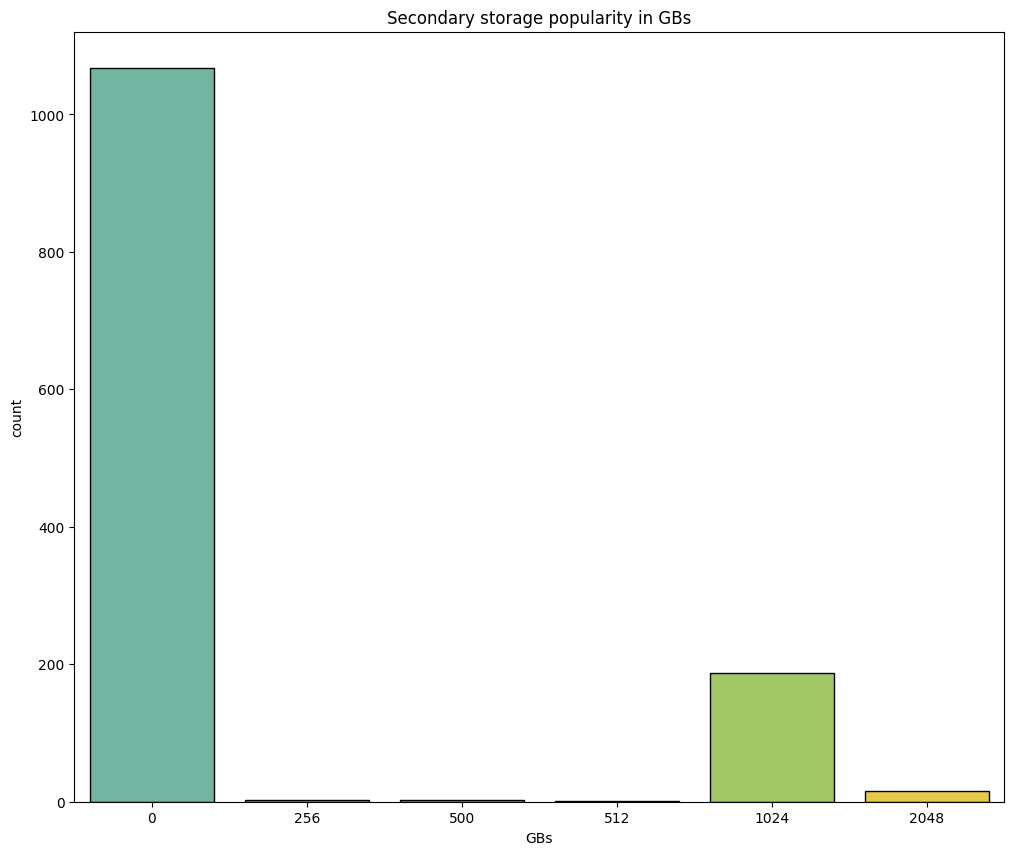

In [27]:
plt.figure(figsize = (12,10))
sns.countplot(x = "SecondaryStorage",
              data = path_df,
              palette = "Set2",
              edgecolor = "black")
plt.title("Secondary storage popularity in GBs")
plt.xlabel("GBs")
plt.show()

### ~`PrimaryStorageType`
**SSDs** generally have been the most popular storage type due to their fast read and write frequency & longevity

C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\2703707827.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "PrimaryStorageType",


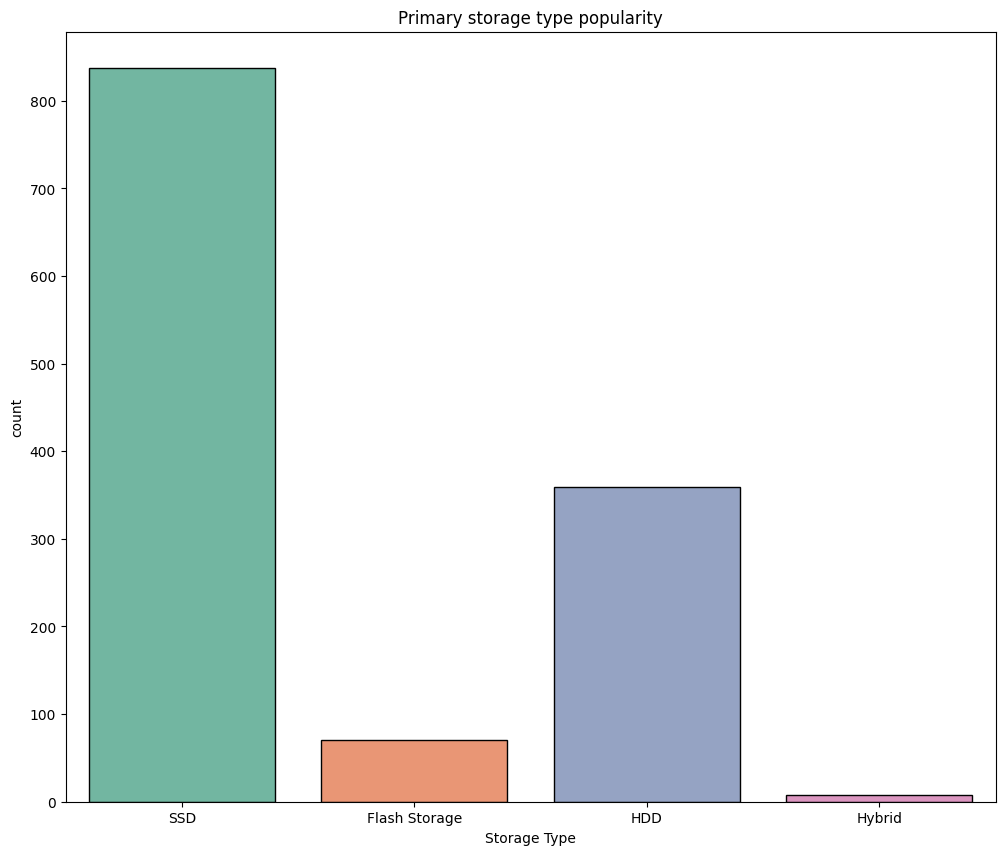

In [28]:
plt.figure(figsize = (12,10))
sns.countplot(x = "PrimaryStorageType",
              data = path_df,
              palette = "Set2",
              edgecolor = "black")
plt.title("Primary storage type popularity")
plt.xlabel("Storage Type")
plt.show()

### ~`SecondaryStorageType`
Surprisingly laptops that do have a seconadry storage installed usually use **HDD** which means that usually use secondary storage to store important files and don't need to use the massive read & write speeds that an **SSD** provides

C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\1872895089.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "SecondaryStorageType",


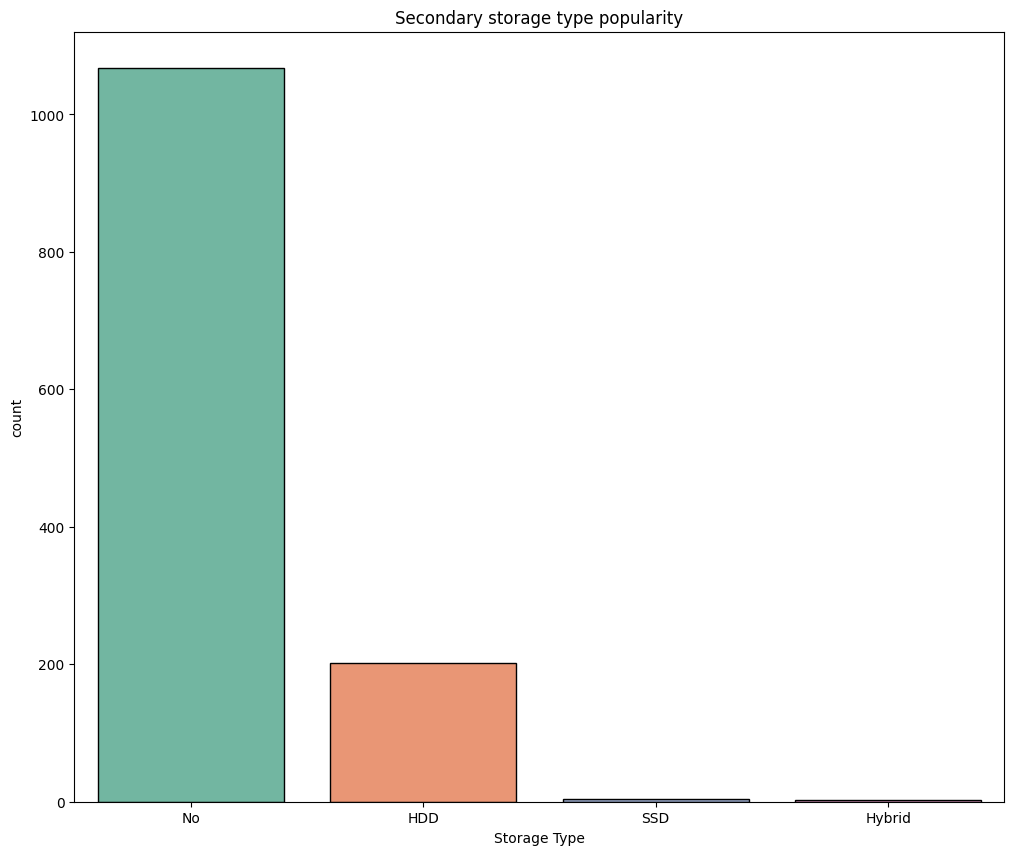

In [29]:
plt.figure(figsize = (12,10))
sns.countplot(x = "SecondaryStorageType",
              data = path_df,
              palette = "Set2",
              edgecolor = "black")
plt.title("Secondary storage type popularity")
plt.xlabel("Storage Type")
plt.show()

### ~`GPU_company`
**Intel** has the largest market share which is expected due to them winning by a landslide in CPUs as well

C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\2011017376.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "GPU_company",


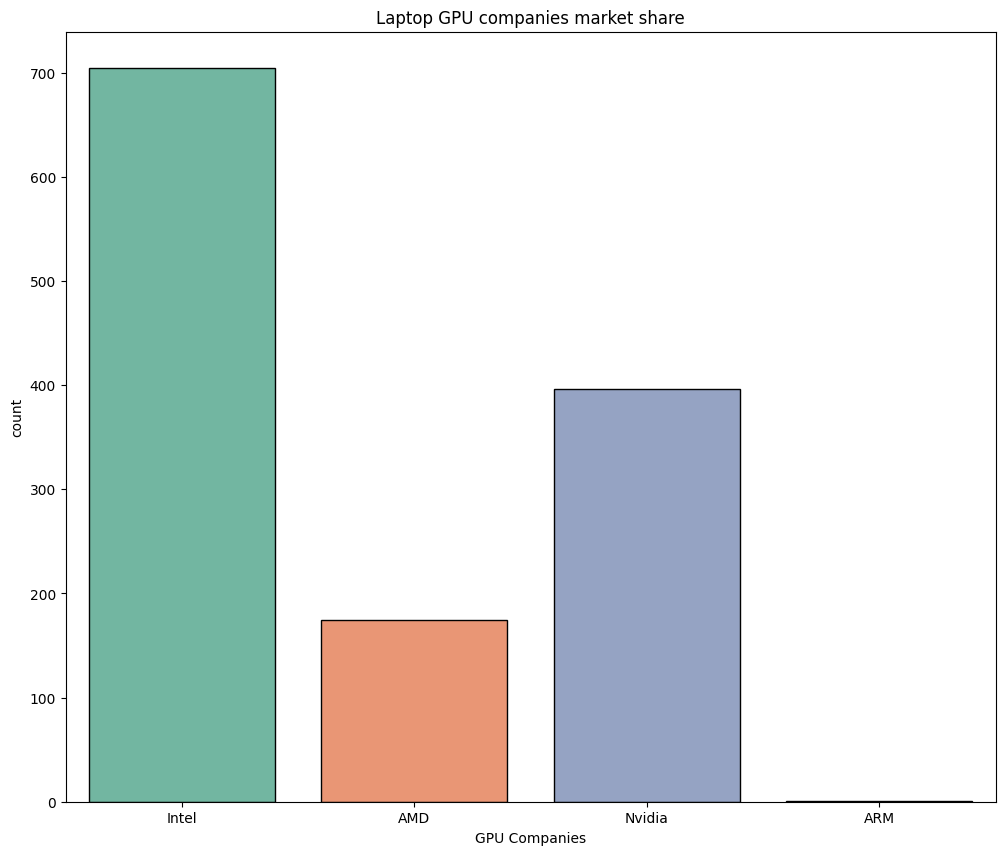

In [30]:
plt.figure(figsize = (12,10))
sns.countplot(x = "GPU_company",
              data = path_df,
              palette = "Set2",
              edgecolor = "black")
plt.title("Laptop GPU companies market share")
plt.xlabel("GPU Companies")
plt.show()

### ~`GPU_model`
**Intel integrated graphics** had the highest market share due to them being present in most budget to medium priced laptop without a dedicated GPU

C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\1581802916.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "GPU_series",


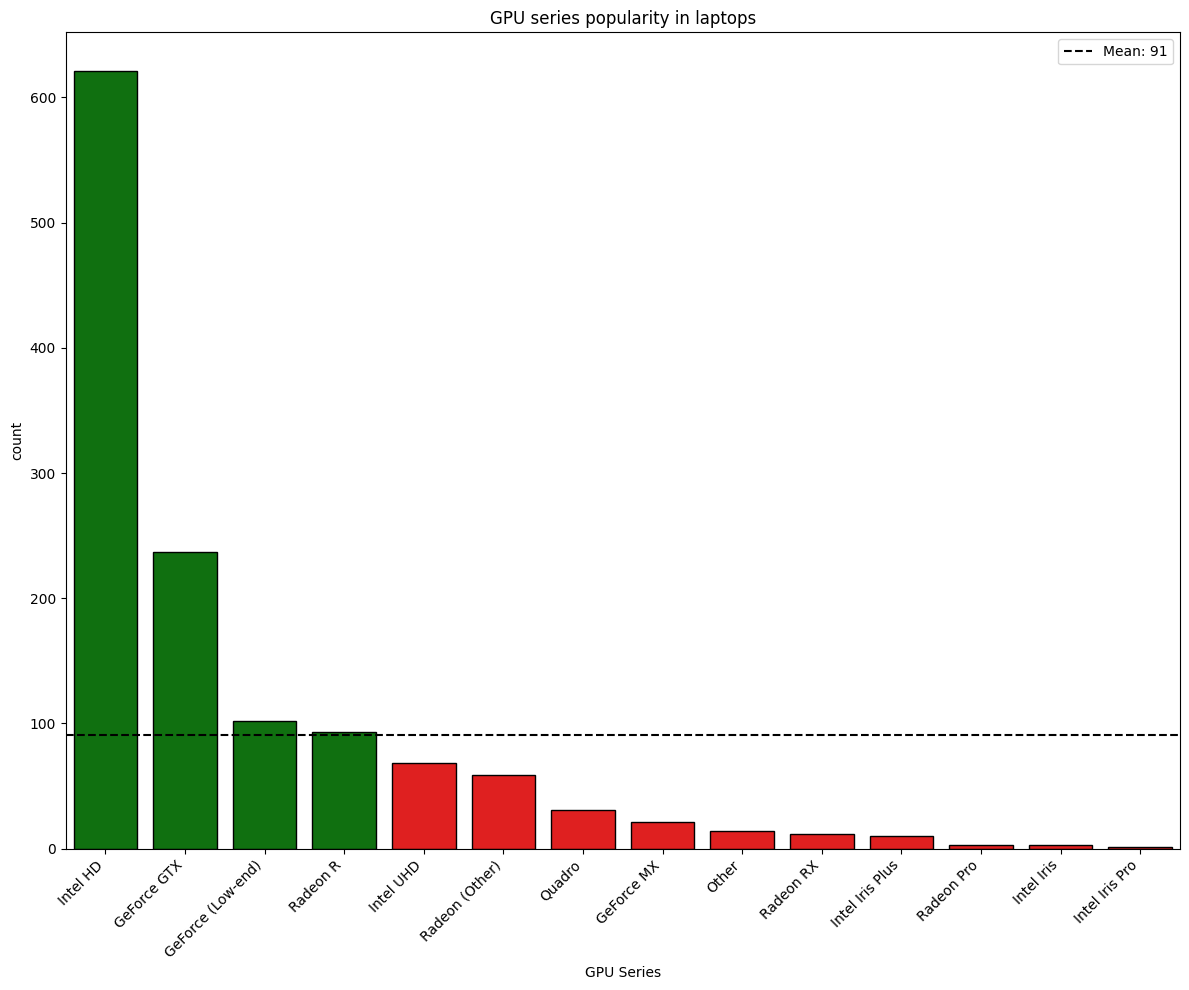

In [31]:
# Extracting GPU series
def extract_gpu_model(gpu_string):
    gpu_string = str(gpu_string)
    
    # NVIDIA patterns
    if re.search(r'GTX', gpu_string, re.IGNORECASE):                    # GTX
        return "GeForce GTX"
    elif re.search(r'MX\d{3}', gpu_string, re.IGNORECASE):              # MX
        return "GeForce MX"
    elif re.search(r'GeForce \d{3}', gpu_string, re.IGNORECASE):        # GeForce
        return "GeForce (Low-end)"
    elif re.search(r'Quadro', gpu_string, re.IGNORECASE):               # Quadro
        return "Quadro"
    
    # AMD patterns
    elif re.search(r'Radeon Pro', gpu_string, re.IGNORECASE):           # Radeon Pro
        return "Radeon Pro"
    elif re.search(r'Radeon RX', gpu_string, re.IGNORECASE):            # Radeon RX
        return "Radeon RX"
    elif re.search(r'Radeon R\d', gpu_string, re.IGNORECASE):           # Radeon R
        return "Radeon R"
    elif re.search(r'Radeon', gpu_string, re.IGNORECASE):               # Radeon 530, etc...
        return "Radeon (Other)"
    
    # Intel patterns
    elif re.search(r'UHD Graphics', gpu_string, re.IGNORECASE):         # UHD Graphics 550, etc...
        return "Intel UHD"
    elif re.search(r'Iris Plus', gpu_string, re.IGNORECASE):            # Iris
        return "Intel Iris Plus"
    elif re.search(r'Iris Pro', gpu_string, re.IGNORECASE):             # Iris Pro
        return "Intel Iris Pro"
    elif re.search(r'Iris', gpu_string, re.IGNORECASE):                 # Iris
        return "Intel Iris"
    elif re.search(r'HD Graphics', gpu_string, re.IGNORECASE):          # HD Graphics
        return "Intel HD"
    
    return "Other"

path_df["GPU_series"] = path_df["GPU_model"].apply(extract_gpu_model)
gpu_series_counts = path_df["GPU_series"].value_counts()
avg_gpu_series = gpu_series_counts.mean()

colors = ["green" if count > avg_gpu_series else "red" for count in gpu_series_counts]

plt.figure(figsize = (12, 10))
sns.countplot(x = "GPU_series",
              data = path_df,
              palette = colors,
              order = gpu_series_counts.index,
              edgecolor = "black")
plt.axhline(y = avg_gpu_series,
            color = "black",
            linestyle = "--",
            label = f"Mean: {avg_gpu_series:.0f}")
plt.legend()
plt.title("GPU series popularity in laptops")
plt.xlabel("GPU Series")
plt.xticks(rotation = 45, ha = "right")
plt.tight_layout()
plt.show()

### Correlation Matrix (Before Transformation)

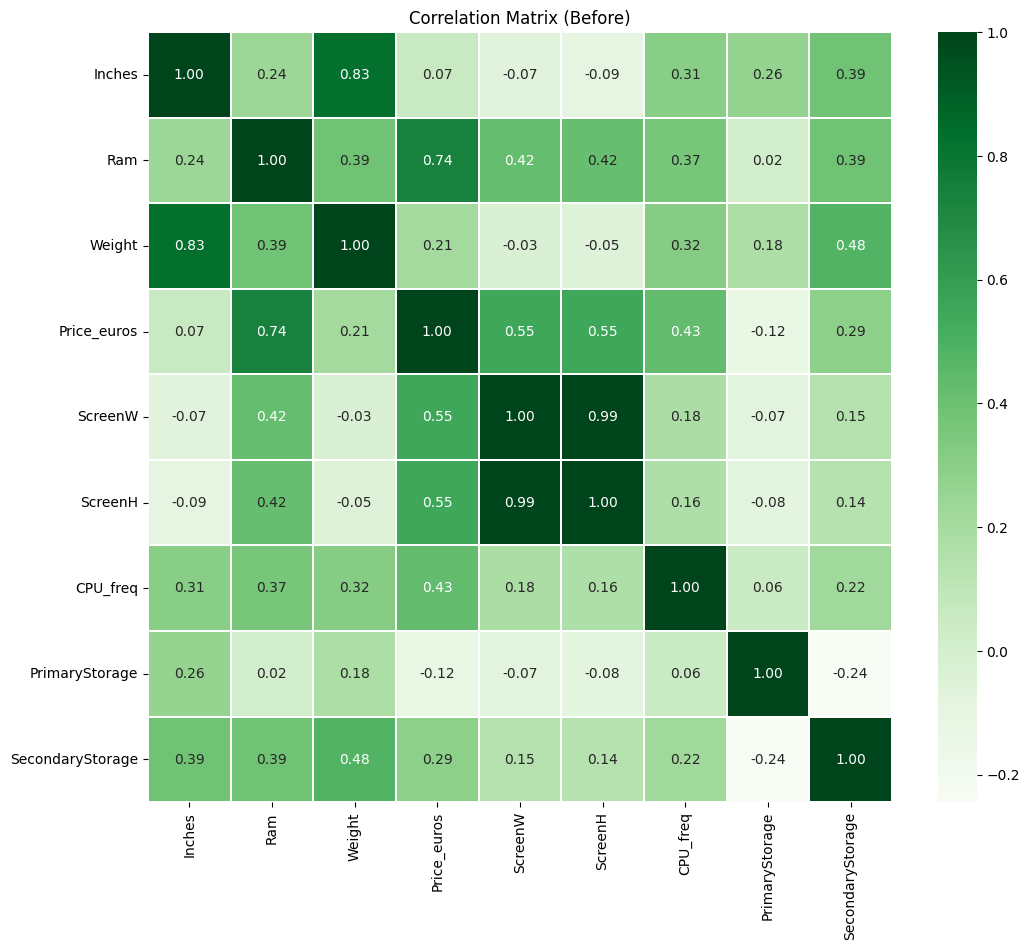

In [32]:
num_df = path_df.select_dtypes("number")
plt.figure(figsize = (12,10))
sns.heatmap(num_df.corr(),
            annot = True,
            cmap = "Greens",
            fmt = ".2f",
            linewidths = 0.2)
plt.title("Correlation Matrix (Before)")
plt.show()

## Choosing the variables (Feature Engineering)

### Pipeline configuration

In [33]:
# Transformations & encoding groups
te_cols = ["Company", "CPU_series", "GPU_series"]

ohe_cols = ['TypeName', 'OS', 'Screen', 'CPU_company', 
            'PrimaryStorageType', 'SecondaryStorageType', 'GPU_company']

binary_cols = ["Touchscreen", "IPSpanel", "RetinaDisplay"]

log_cols = ["PrimaryStorage", "SecondaryStorage"]

# Columns getting dropped
drop_cols = ['Product', 'CPU_model', 'GPU_model', 'ScreenW', 'ScreenH', 'Resolution']

# Scaling groups
robust_features = ['Ram', 'PrimaryStorage', 'SecondaryStorage']
standard_features = ['Inches', 'CPU_freq', 'Pixels', "Weight"]

### Pipeline setup

In [34]:
# Complete pipeline with any regressor, auto log1p/expm1 on price.
def build_pipeline(model, n_clusters = 4):

    return Pipeline([
        # Feature engineering
        ("cpu_extract", CPUSeriesExtractor()),
        ("gpu_extract", GPUSeriesExtractor()),
        ("pixels", PixelCalculator(log_transform=True)),
        ("log_storage", LogTransformer(columns=log_cols)),
        ("cardinality", CardinalityReducer(
            columns=te_cols,
            threshold="mean",
            exceptions={"Company": ["Apple"]}
        )),
        ("drop", ColumnDropper(columns = drop_cols)),
        
        # Encoding & scaling
        ("encoding_scaling", ColumnTransformer(transformers =[
            ("te", TargetEncoder(cv = 5, smooth= "auto"), te_cols), # Has built in auto smoothing 
            ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse_output = False, drop = "first"), ohe_cols),
            ("binary", OrdinalEncoder(), binary_cols),
            ("robust", RobustScaler(), robust_features),
            ("std", StandardScaler(), standard_features)
        ], remainder = "passthrough")),
        
        # Clustering
        ("cluster", KMeansClusterAdder(n_clusters = n_clusters)),
        
        # Log transformations
        ("model", TransformedTargetRegressor(
            regressor = model,
            func = np.log1p,
            inverse_func = np.expm1
        ))
    ])

# Complete model hyperparameter tuning, training, & testing, outputing metrics
def tune_and_evaluate(name, model, param_config, X_train, X_test, y_train, y_test):
    pipe = build_pipeline(model)
    
    # Filters parameter labeling from pipeline
    prefixed_params = {
        f"model__regressor__{k}": v for k, v in param_config["params"].items()
    }
    
    if not prefixed_params:
        pipe.fit(X_train, y_train)
        best_pipe = pipe
        best_params_clean = {}
        
    elif param_config["method"] == "random": # RandomSearchCV()
        rand_search = RandomizedSearchCV(
            estimator = pipe,
            param_distributions = prefixed_params,
            n_iter = param_config.get("n_iter", 100),
            cv = 10,
            scoring = "neg_mean_absolute_error",
            n_jobs = -1,
            verbose = 1,
            random_state = 90
        )
        rand_search.fit(X_train, y_train)
        best_pipe = rand_search.best_estimator_
        best_params_clean = {k.replace("model__regressor__", ""): v for k, v in rand_search.best_params_.items()}
        
    elif param_config["method"] == "grid": # GridSearchCV()
        grid_search = GridSearchCV( 
            estimator = pipe,
            param_grid = prefixed_params,
            cv = 10,
            scoring = "neg_mean_absolute_error",
            n_jobs = -1,
            verbose = 1
        )
        grid_search.fit(X_train, y_train)
        best_pipe = grid_search.best_estimator_
        best_params_clean = {k.replace("model__regressor__", ""): v for k, v in grid_search.best_params_.items()}
        
    else:
        bay_search = BayesSearchCV(
            estimator = pipe,
            search_spaces = prefixed_params,
            cv = 10,
            scoring = "neg_mean_absolute_error",
            n_jobs = -1,
            verbose = 0,
            random_state = 72
        )
        bay_search.fit(X_train, y_train)
        best_pipe = bay_search.best_estimator_
        best_params_clean = {k.replace("model__regressor__", ""): v for k, v in bay_search.best_params_.items()}
        
    y_pred = best_pipe.predict(X_test)
    
    results = {
        "Model": name,
        "  R2": r2_score(y_test, y_pred),
        " MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": root_mean_squared_error(y_test, y_pred)
    }
    
    print(f"\n===={name} results====\n")
    if best_params_clean:
        print(f"    Method: {param_config['method'].upper()}")
        print(f"    Best parameters: {best_params_clean}")
    for metric, value in results.items():
        if metric != "Model":
            print(f"    {metric}: {value:.2f}")
    print("\n--------------------------\n")
    return results, best_pipe

# Task 2

## Setting up data for modeling

In [35]:
path_df = pd.read_csv(r"laptop_prices.csv")

X = path_df.drop(columns = "Price_euros")
y = path_df["Price_euros"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 50, test_size = 0.2)

print(f"Training on {X_train.shape[0]} laptops.")
print(f"Testing on {X_test.shape[0]} laptops.")

Training on 1020 laptops.
Testing on 255 laptops.


## Model Setup
XGBoost model wins by a significant margin compared to other models in terms of **R2**, **MAE**, & **RMSE** 

In [37]:
# LinearRegression()
lr_results, lr_model_pipe = tune_and_evaluate(
    "Linear Regression", LinearRegression(),
    {"method": None, "params": {}}, # LR is non hyperparametic
    X_train, X_test, y_train, y_test    
)

# ElasticNetCV()
en_results, en_model_pipe = tune_and_evaluate(
    "Elastic Net", ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                                cv = 5,
                                random_state = 5,
                                alphas = np.logspace(-4, 1, 100),  # force search over smaller alphas
                                max_iter = 10000),
    {"method": None, "params": {}},
    X_train, X_test, y_train, y_test
)


# RandomForestRegressor()
rfr_results, rfr_model_pipe = tune_and_evaluate(
    "Random Forest Regressor", RandomForestRegressor(random_state = 42),
    {
        "method": "random",
        "n_iter": 100,
        "params": { # Model Parameters
            "n_estimators": randint(100, 500), # number of trees
            "max_depth": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None], # maximum number of levels
            "min_samples_split": randint(2, 10), # minimum number of samples required to split a node
            "max_features": ["sqrt", "log2", 1.0] # number of features to consider on every split
        }
    },
    X_train, X_test, y_train, y_test
)

# XGBoost
xgb_results, xgb_model_pipe = tune_and_evaluate(
    "XGBoost", XGBRegressor(
        objective = "reg:squarederror", # focusing on minimizing squared error
        tree_method = "hist", # histogram binning trees for higher speeds
        random_state = 67,
        n_jobs = -1 # full powaaaaaaaaa
    ),
    {"method": "grid",
     "n_iter": 100,
     "params": {
        "n_estimators": [1000, 1100, 1150, 1200],
        "max_depth": [5, 6, 7],
        "eta": [0.01, 0.02 , 0.03], # learning rate
        "subsample": [0.5, 0.6, 0.7], # prevents overfitting by using % of the testing rows per tree
        "colsample_bytree": [0.8, 0.7, 0.9] # same as subsampling but hides features (RF feature bagging)
     }
    },
    X_train, X_test, y_train, y_test
)

# LightGBM
lgbm_results, lgbm_model_pipe = tune_and_evaluate(
    "LightGBM", LGBMRegressor(
        random_state= 67,
        n_jobs = -1,
    ),
    {"method": "baysian", # Using baysian search due being more compatible 
     "n_iter": 50, # baysian doesn't need 100
     "params": {
         "objective": Categorical(["regression"]),
         "boosting_type": Categorical(["dart", "gbdt"]), # dart boosing is effective but takes alot of time due to the larger processing load
         "max_depth": Integer(3, 6),
         "learning_rate": Real(0.1, 0.3), # eta
         "num_leaves": Integer(100, 200), 
         "n_estimators": Integer(900, 1500)
     }
            
    },
    X_train, X_test, y_train, y_test
        )

comparison = pd.DataFrame([lr_results, en_results, rfr_results, xgb_results, lgbm_results])
comparison.sort_values("  R2", ascending = False).round(2)

c:\Users\medo7\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [3, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)



====Linear Regression results====

      R2: 0.72
     MAE: 233.13
    RMSE: 363.31

--------------------------



c:\Users\medo7\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [3, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)



====Elastic Net results====

      R2: 0.73
     MAE: 233.71
    RMSE: 358.17

--------------------------

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


c:\Users\medo7\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [3, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)



====Random Forest Regressor results====

    Method: RANDOM
    Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 349}
      R2: 0.81
     MAE: 185.32
    RMSE: 300.34

--------------------------

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


c:\Users\medo7\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [3, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)



====XGBoost results====

    Method: GRID
    Best parameters: {'colsample_bytree': 0.7, 'eta': 0.01, 'max_depth': 6, 'n_estimators': 1200, 'subsample': 0.5}
      R2: 0.87
     MAE: 158.45
    RMSE: 245.04

--------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 1020, number of used features: 32
[LightGBM] [Info] Start training from score 6.868798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\medo7\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [3, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\medo7\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Model,R2,MAE,RMSE
3,XGBoost,0.87,158.45,245.04
4,LightGBM,0.86,157.26,255.33
2,Random Forest Regressor,0.81,185.32,300.34
1,Elastic Net,0.73,233.71,358.17
0,Linear Regression,0.72,233.13,363.31


### Correlation Matrix (After transformation)

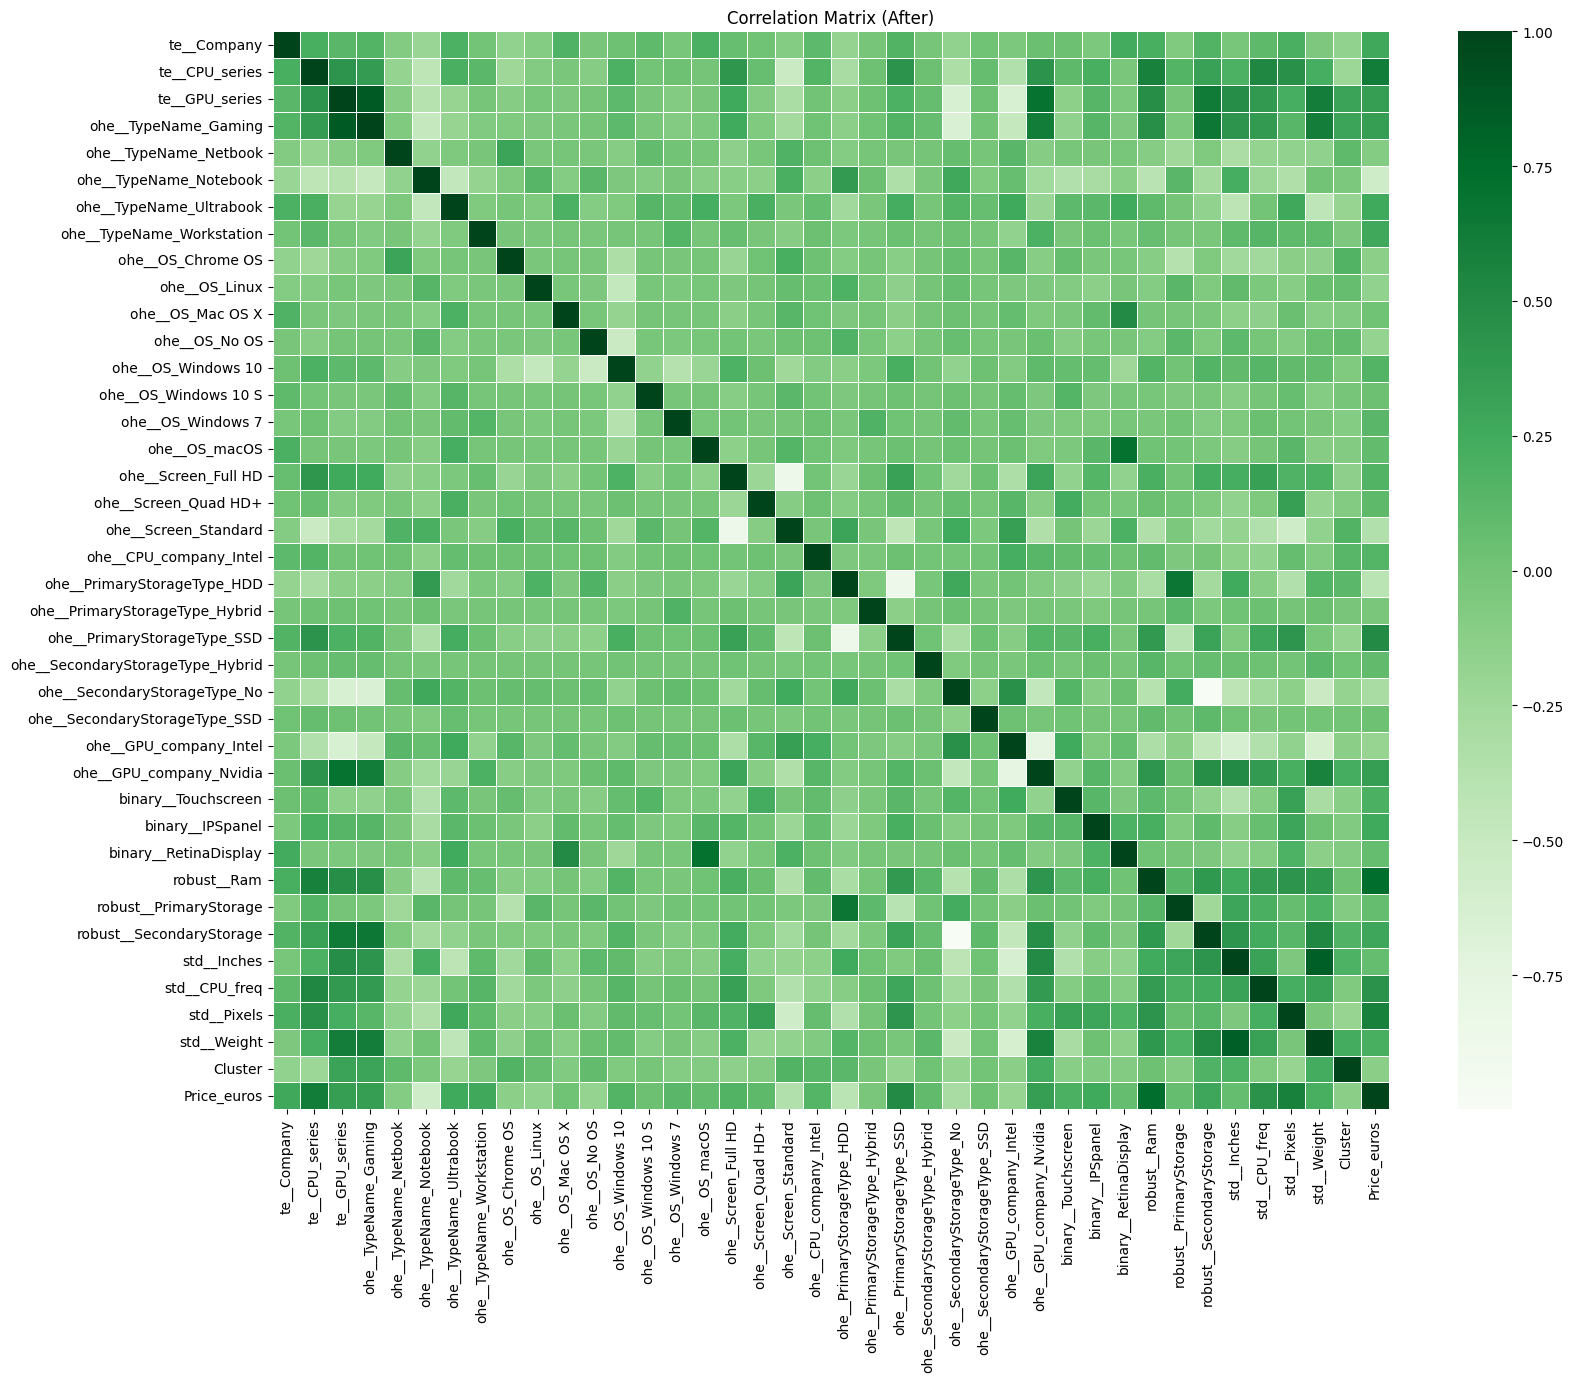

In [38]:
data_engine = xgb_model_pipe[:-1]

X_transformed = data_engine.transform(X_train)

coltrans = xgb_model_pipe.named_steps["encoding_scaling"]
feature_names = list(coltrans.get_feature_names_out()) + ["Cluster"]

df_corr = pd.DataFrame(X_transformed, columns=feature_names)
df_corr["Price_euros"] = y_train.values

plt.figure(figsize=(18, 14))
sns.heatmap(df_corr.corr(),
            annot=False,
            cmap="Greens",
            linewidths=0.5)
plt.title("Correlation Matrix (After)")
plt.show()

## Feature Importance
Although it would seem that some features are redundant looking at the chart but the numbers say otherwise, keeping these features although they don't deliver significant importance random forest uses feature bagging which uses different combinations which could result in better accuracy overall

C:\Users\medo7\AppData\Local\Temp\ipykernel_18808\4048578598.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = "importance",


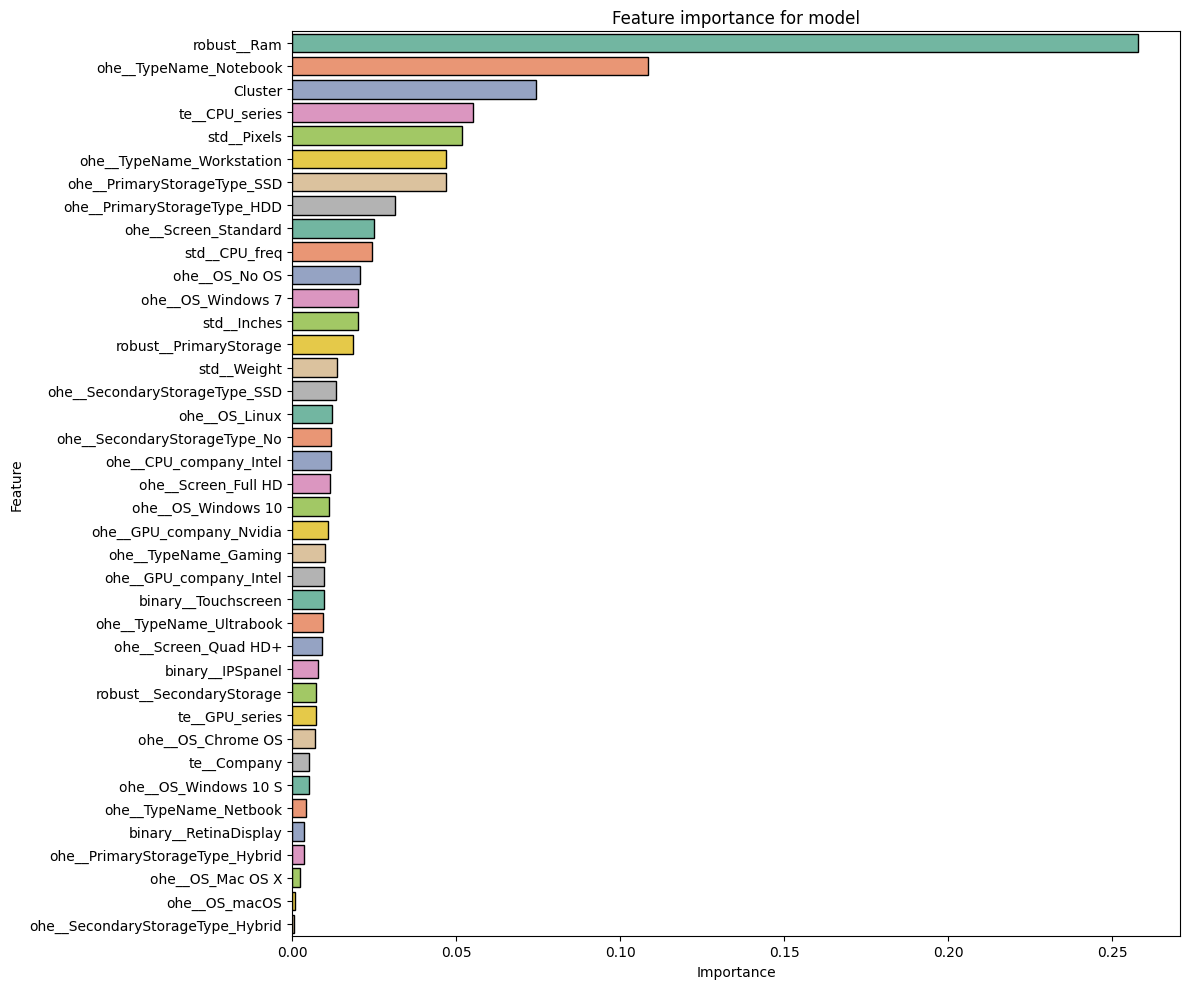

In [39]:
# Access the actual model inside the pipeline
xgb_core = xgb_model_pipe.named_steps["model"].regressor_
coltrans = xgb_model_pipe.named_steps["encoding_scaling"]
cluster = xgb_model_pipe.named_steps["cluster"]

feature_names = cluster.get_feature_names_out(coltrans.get_feature_names_out())
importances = xgb_core.feature_importances_

feature_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by = "importance", ascending = False)

plt.figure(figsize = (12,10))
sns.barplot(x = "importance",
            y = "feature",
            data = feature_importance,
            palette = "Set2",
            edgecolor = "black")
plt.title("Feature importance for model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Task 3

## Identifying our K
Using **Elbow plot** to identify the best K for clustering

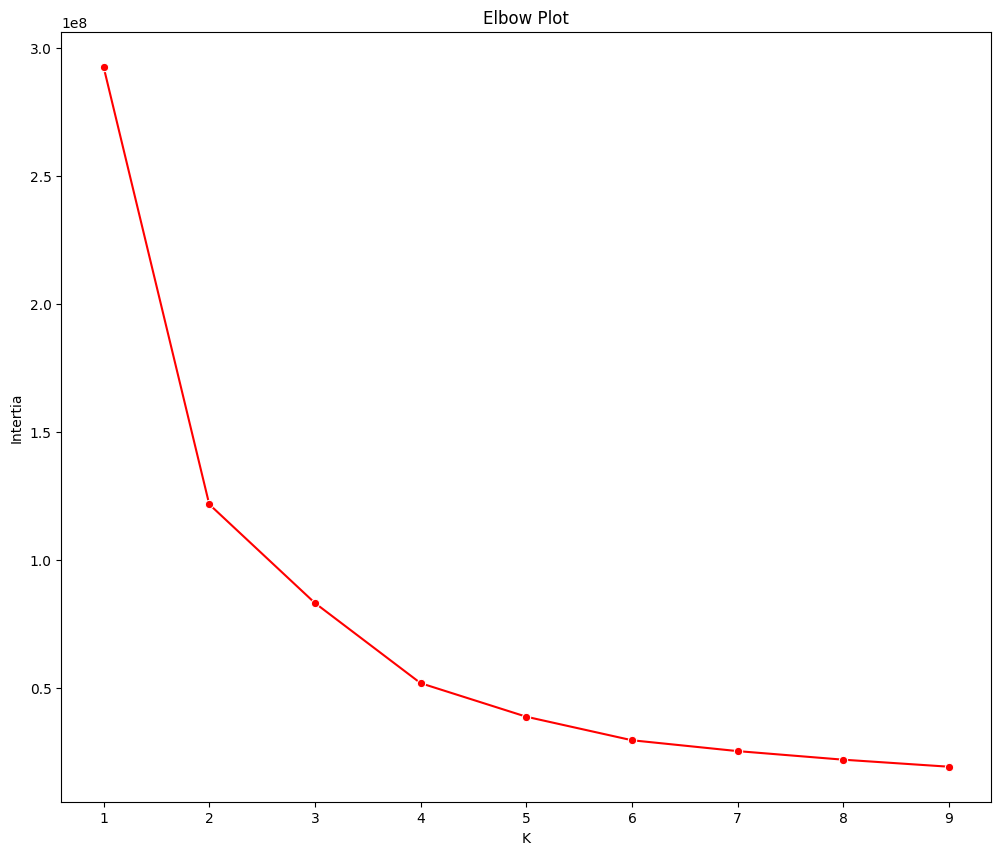

Best K = 4


In [40]:
pre_cluster_pipe = xgb_model_pipe[: -2] # Setting up pipeline without the y_transformation to for clustering set up

X_transformed = pre_cluster_pipe.transform(X_train) # Scaling & encoding data

inertia = []

for k in range(1, 10):
    km = KMeans(n_clusters = k, 
                random_state = 42,
                n_init = 10) # Clusters 10 times to avoid bad clusterings
    km.fit_transform(X_transformed)
    inertia.append(km.inertia_)
    
plt.figure(figsize = (12, 10))
sns.lineplot(x = range(1, 10),
                y = inertia,
                marker = "o",
                color = "red")
plt.xlabel("K")
plt.ylabel("Intertia")
plt.title("Elbow Plot")
plt.show()
print("Best K = 4")

Now I'll setup the clustering algorithm in the pipeline

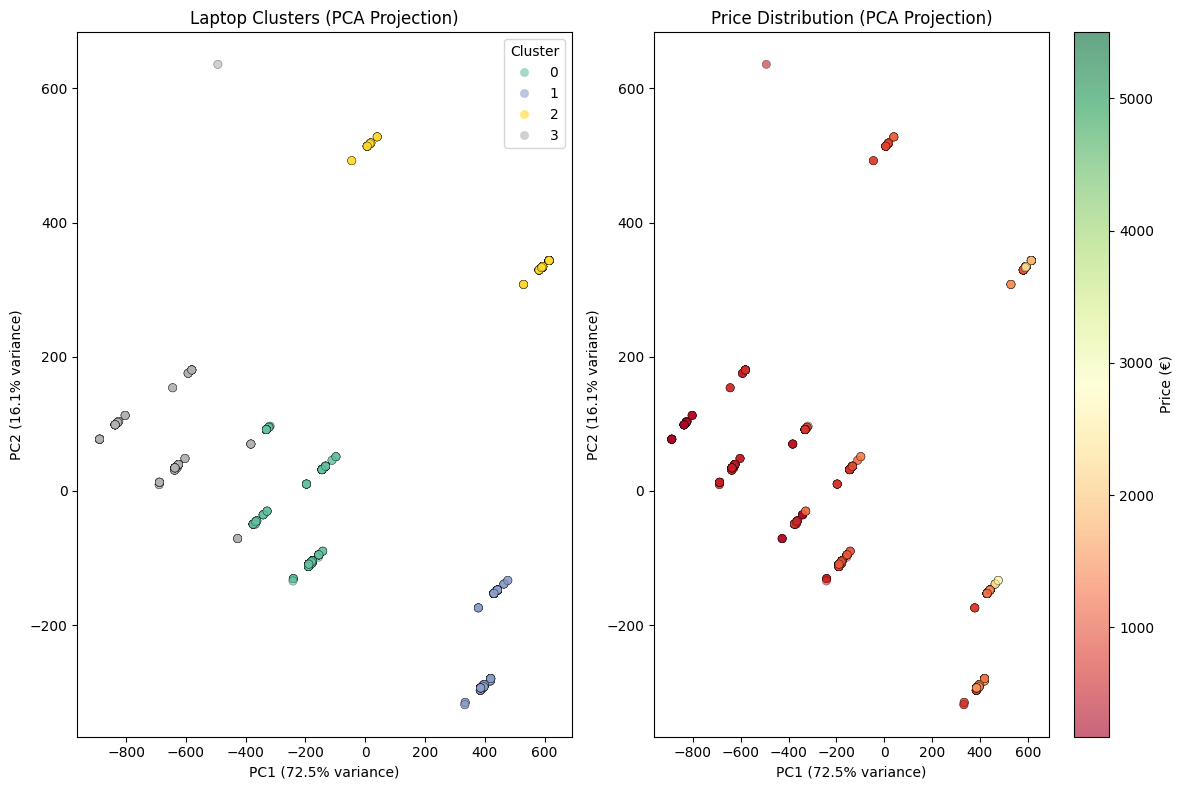

In [41]:
labels = cluster.kmeans_.predict(X_transformed)

# Attaching Cluster column back to the training dataset
cluster_df = X_train.copy()
cluster_df["Cluster"] = labels
cluster_df["Price"] = y_train.values

# Visualizing clusters
pca = PCA(n_components = 2, random_state = 42)
X_2d = pca.fit_transform(X_transformed)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))

scatter1 = ax1.scatter(X_2d[:, 0],
                       X_2d[:, 1],
                       c = labels,
                       cmap = "Set2",
                       alpha = 0.6,
                       edgecolor = "black",
                       linewidth = 0.3)
ax1.set_title("Laptop Clusters (PCA Projection)")
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
ax1.legend(*scatter1.legend_elements(), title = "Cluster")

scatter2 = ax2.scatter(X_2d[:, 0],
                       X_2d[:, 1],
                       c = y_train.values,
                       cmap = "RdYlGn",
                       alpha = 0.6,
                       edgecolor = "black",
                       linewidth = 0.3)
ax2.set_title("Price Distribution (PCA Projection)")
ax2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
ax2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.colorbar(scatter2, ax = ax2, label = "Price (€)")

plt.tight_layout()
plt.show()

## Business Insights

Based on the cluster analysis, laptops naturally group into distinct market segments:

- **Cluster 0** — Budget laptops: Low RAM, basic CPUs, smaller screens
- **Cluster 1** — Mid-range notebooks: Standard specs, most popular segment  
- **Cluster 2** — Premium ultrabooks: High resolution, lightweight, premium pricing
- **Cluster 3** — Performance/Gaming: High RAM, powerful CPUs, heaviest & most expensive

                                                                    === Price per Cluster ===


,Mean €,Median €,Count,Min €,Max €
Cluster,,,,,
0,977.99,917.0,374,191.9,4899.00
1,1512.53,1414.0,272,598.0,3949.40
2,1657.43,1399.0,190,589.0,5499.00
3,453.57,439.0,184,174.0,1166.97



                                                                === Hardware Profile per Cluster ===


,Avg_Ram,Avg_Weight,Avg_Inches,Avg_CPU_freq,Avg_Storage,Top_Type,Top_Company,Top_OS
Cluster,,,,,,,,
0,6.67,1.85,14.66,2.20,415.57,Notebook,HP,Windows 10
1,10.41,1.82,14.75,2.44,468.04,Notebook,Lenovo,Windows 10
2,13.72,2.87,16.32,2.71,393.43,Gaming,Asus,Windows 10
3,4.38,1.93,14.81,1.88,492.54,Notebook,Acer,Windows 10


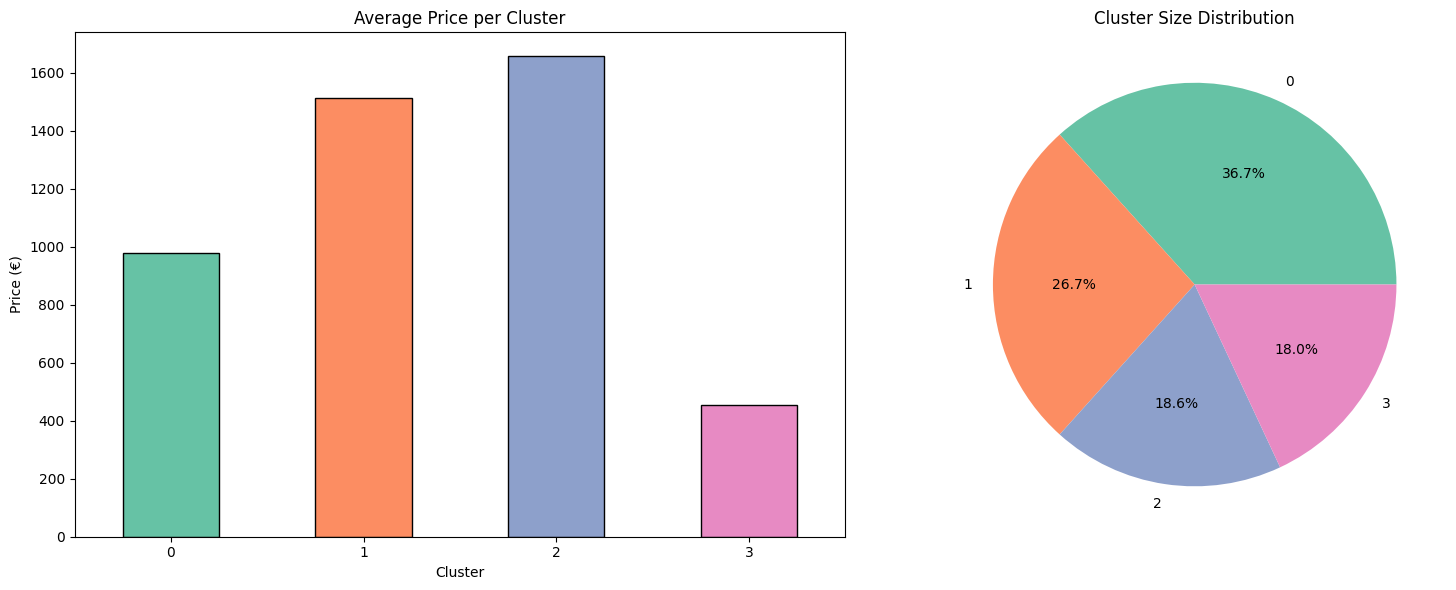

In [42]:
# Price breakdown per cluster
price_summary = cluster_df.groupby("Cluster")["Price"].agg(
    ["mean", "median", "count", "min", "max"]
).round(2)
price_summary.columns = ["Mean €", "Median €", "Count", "Min €", "Max €"]
print("                                                                    === Price per Cluster ===")
display(price_summary)

# Hardware profile per cluster
hardware_summary = cluster_df.groupby("Cluster").agg(
    Avg_Ram = ("Ram", "mean"),
    Avg_Weight = ("Weight", "mean"),
    Avg_Inches = ("Inches", "mean"),
    Avg_CPU_freq = ("CPU_freq", "mean"),
    Avg_Storage = ("PrimaryStorage", "mean"),
    Top_Type = ("TypeName", lambda x: x.mode()[0]),
    Top_Company = ("Company", lambda x: x.mode()[0]),
    Top_OS = ("OS", lambda x: x.mode()[0])
).round(2)
print("\n                                                                === Hardware Profile per Cluster ===")
display(hardware_summary)

# Cluster size distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

cluster_df.groupby("Cluster")["Price"].mean().plot(kind = "bar",
                                                   color = sns.color_palette("Set2"),
                                                   edgecolor = "black",
                                                   ax = ax1)
ax1.set_title("Average Price per Cluster")
ax1.set_ylabel("Price (€)")
ax1.tick_params(axis = "x", rotation = 0)

cluster_df["Cluster"].value_counts().sort_index().plot(kind = "pie",
                                                       colors = sns.color_palette("Set2"),
                                                       autopct = "%1.1f%%",
                                                       ax = ax2)
ax2.set_title("Cluster Size Distribution")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()

# Model deployment
Dumping the models into a folder for later use in dashboard

In [43]:
os.makedirs("models", exist_ok = True)

models = {
    "linear_regression": lr_model_pipe,
    "elastic_net": en_model_pipe,
    "random_forest_regressor": rfr_model_pipe,
    "xgboost": xgb_model_pipe,
    "lightgbm": lgbm_model_pipe
}

for name, pipe in models.items():
    joblib.dump(pipe, f"models/{name}_pipe.joblib")
    print(f"✅ Saved {name} → models/{name}_pipe.joblib")
    
joblib.dump(comparison, "models/comparison.joblib")
joblib.dump({"X_test": X_test, "y_test": y_test}, "models/test_data.joblib")

print("\nAll models saved to ./models/ successfully")

✅ Saved linear_regression → models/linear_regression_pipe.joblib
✅ Saved elastic_net → models/elastic_net_pipe.joblib
✅ Saved random_forest_regressor → models/random_forest_regressor_pipe.joblib
✅ Saved xgboost → models/xgboost_pipe.joblib
✅ Saved lightgbm → models/lightgbm_pipe.joblib

All models saved to ./models/ successfully
